# Chaining search



## Sphinx documentatie: https://pythonhosted.org/an_example_pypi_project/sphinx.html
## in voorbeelden handige python functies opnemen
## zoals ; .sort_values(ascending=False,by=['raw_freq']));  list enz


## Library functions: Search
 

In [1]:
from nltk.tag.perceptron import PerceptronTagger

'''
Return a Pandas DataFrame filtered according to a set of parameters
Args:
    df: Pandas DataFrame to filter on
    df: column on which we filter
    method: "regex" of "isin"
    regex_or_set: Regular expression (if method=="regex") or set (if method=="isin")
'''
def filter_df(df, column, method, regex_or_set):
    
    if method=="regex":
        filter_condition = df[column].str.contains(regex_or_set)
    elif method=="isin":
        filter_condition = df[column].isin(regex_or_set)
    else:
        raise ValueError("method should be one of regex or isin")
    return df[filter_condition]
    


def concat_df(df_arr, keys_arr=None):
    '''
    This function concatenates two dataframes 
    Args:
        df_arr: array of Pandas DataFrames
        keys_arr: array of keys to assign to the records of each DataFrame, so we can still distinguish the original DataFrames
    Returns:
        a single Pandas DataFrame 
        
    >>> new_df = concat_df( [dataframe1, dataframe2, dataframe3], ['chn corpus', 'nederlab', 'opensonar'] )
    >>> display_df(new_df)
    '''
    # ref: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
    
    if keys_arr is not None:
        concat_df = pd.concat( df_arr, keys=keys_arr )
    else:
        concat_df = pd.concat( df_arr )
    
    return concat_df



def join_df(df_arr, join_type=None):
    
    '''
    This function joins two dataframes (=concat along axis 1) 
    Args:
        df_arr: array of Pandas DataFrames
        join_type: {inner, outer (default)}
    Returns:
        a single Pandas DataFrame 
        
    >>> new_df = join_df( [dataframe1, dataframe2] )
    >>> display_df(new_df)
    '''
    
    # ref: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
    
    if join is None:
        concat_df = pd.concat( df_arr, axis=1 )
    else:
        concat_df = pd.concat( df_arr, axis=1, join=join_type )
    
    return concat_df

    
    

def get_tagger(df_corpus):
    '''
    This function instantiates a tagger trained with some corpus annotations 
    Args:
        df_corpus: Pandas DataFrame with annotated corpus data
    Returns:
        a PerceptronTagger instance 
    
    >>> tagger = get_tagger(df_corpus)  # df_corpus containes a Pandas DataFrame with lots of corpus data
    >>> sentence = 'Here is some beautiful sentence'
    >>> tagged_sentence = tagger.tag( sentence.split() )
    >>> print(tagged_sentence) 
    
    '''
    
    # The corpus DataFrame consists of a number of sentences (rows) with a fixed number of tokens.
    # Each token has a fixed number of layers holding info like: lemma, wordform or part-of-speech. 
    # As a result, the number of columns of each row = [number of tokens] x [number of layers]
    
    # To be able to feed the tagger correctly, we need to compute the number of layers,
    # so we can infer the number of tokens the sentences hold. This is because
    # the tagger expects us to feed it with arrays with length = [number of tokens], as elements of
    # one single array holding all sentences arrays (see below).
    
	# So, determine how many layers (lemma, pos, wordform) we have 
	column_names = list(df_corpus.columns.values)
	for n, val in enumerate(column_names):
        # remove the numbers at the end of the layers names (lemma 1, lemma 2, ..., pos 1, pos 2, ...)
        # so we end up with clean layers name only
		column_names[n] = val.split(' ')[0] 
	number_of_layers = len(set(column_names))

    # Now we can determine the standard length of our corpus sentences: that can be computed 
    # by dividing the number of columns of the corpus DataFrame by the number of layers
    # we just computed.
	sentences = []
	nr_of_words_per_sentence = int( df_corpus.shape[1] / number_of_layers )  

    # Build training data for the tagger in the right format
    # The input must be like: [ [('today','NN'),('is','VBZ'),('good','JJ'),('day','NN')], [...] ]
	for index, row in df_corpus.iterrows():
		one_sentence =  []
		wrong = False
		for i in range(0, nr_of_words_per_sentence, 1): 
			tuple = ( row['word '+str(i)], row['pos '+str(i)] )
			one_sentence.append( tuple )
			if (row['word '+str(i)] is None or row['pos '+str(i)] is None):
				wrong = True
		if wrong is False:
			sentences.append(one_sentence)

    # Instantiate and train the tagger now
	tagger = PerceptronTagger(load=False)
	tagger.train(sentences)
	
	return tagger

TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-1-6636c85051ed>, line 97)

In [2]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import json
import urllib
#import wx   # for interaction popups          TODO -> omzetten naar JS of zo
import itertools # for frequency list function
import numpy     # idem
from IPython.display import FileLink, FileLinks
AVAILABLE_CORPORA = ['chn', 'opensonar', 'zeebrieven', 'gysseling', 'nederlab']
RECORDS_PER_PAGE = 1000

# Get rid of ellipsis in display (otherwise relevant data might not be shown)
pd.set_option('display.max_colwidth',1000)

# Search methods

def search_corpus_allwords(corpus, pos=None):
    '''
    This function gets all words of a corpus. If needed, the output can be restricted to words with a given part-of-speech
    Args:
        corpus: corpus name
        pos: part-of-speech (optional)
    Returns:
        a Pandas DataFrame containing corpus data
        
    >>> df_corpus = search_corpus_allwords("gysseling")
    >>> display_df(df_corpus)
    '''
    
    query = r'[word=".*"]'
    if pos is not None:
        query = r'[word=".*" & pos="'+pos+r'"]'
    return search_corpus(query, corpus)

def search_corpus_alllemmata(corpus, pos):
    '''
    This function gets all lemmata of a corpus. If needed, the output can be restricted to lemmata with a given part-of-speech
    Args:
        corpus: corpus name
        pos: part-of-speech (optional)
    Returns:
        a Pandas DataFrame containing corpus data
        
    >>> df_corpus = search_corpus_alllemmata("chn")
    >>> display_df(df_corpus)
    '''
    
    query = r'[lemma=".*"]'
    if pos is not None:
        query = r'[lemma=".*" & pos="'+pos+r'"]'
    return search_corpus(query, corpus) 

def search_corpus(query, corpus, start_position=1, detailed_context=False):
    '''
    This function searches a corpus given a query and a corpus name
    Args:
        query: a corpus query, eg. previously generated by corpus_query_lemma() or such
        corpus: a corpus name
        start_position: (optional) corpus response page (usually used by the function automatically calling itself recursively)
        detailed_context: (optional) {True, False (default)} 
    Returns:
        a Pandas DataFrame containing corpus data
        
    >>> df_corpus = search_corpus(r'[pos="ADJ"][word="huis"]', "chn")
    >>> display_df(df_corpus)
    '''
    
    # show wait indicator
    #app = wx.App()
    #msg_to_user = wx.BusyInfo('Searching '+corpus+' corpus')
    if corpus not in AVAILABLE_CORPORA:
        raise ValueError("Unknown corpus: " + corpus)
    try:
        # Do request to federated content search corpora, so we get same output format for every corpus
        url = "http://portal.clarin.inl.nl/fcscorpora/clariah-fcs-endpoints/sru?operation=searchRetrieve&queryType=fcs&maximumRecords=1000&x-fcs-context=" + corpus + "&query=" + urllib.parse.quote(query)
        #print(url)
        response = requests.get(url)
        response_text = response.text    
        df, next_page = _parse_xml(response_text, detailed_context)
        # If there are next pages, call search_corpus recursively
        #print(next_page)
        if next_page > 0:
            df_more = search_corpus(query, corpus, next_page, detailed_context)
            df = df.append(df_more, ignore_index=True)
        # show message out of xml, if some error has occured (prevents empty output)
        _show_error_if_any(response_text)
        return df
    except Exception as e:
        raise ValueError("An error occured when searching corpus " + corpus + ": "+ str(e))
    #finally:
    #    # remove wait indicator, and return dataframe
    #    del msg_to_user        

    
    
def search_corpus_multiple(queries, corpus):
    '''
    This function sends multiples queries at once to the search_corpus function
    Args:
        queries: array of corpus queries, eg. previously generated by corpus_query_lemma() or such
        corpus: a corpus name 
    Returns:
        a dictionary of Pandas DataFrames, associating each query (key) to the resulting corpus data (value)
    '''
    result_dict = {}
    for query in queries:
        result_dict[query] = search_corpus(query,corpus)
    return result_dict
   
    

def search_lexicon_alllemmata(lexicon, pos=None):
    '''
    This function gets all lemmata of a lexicon. If needed, the output can be restricted to lemmata with a given part-of-speech
    Args:
        lexicon: a lexicon name
        pos: part-of-speech (optional)
    Returns:
        a Pandas DataFrame containing lexicon data 
        
    >>> df_corpus = search_corpus_alllemmata("chn")
    >>> display_df(df_corpus)
    '''
    query = lexicon_query_alllemmata(lexicon, pos)
    return search_lexicon(query, lexicon)



def search_lexicon(query, lexicon):
    '''
    This function searches a lexicon given a query and a lexicon name
    Args:
        query: a lexicon query, typically previously generated by lexicon_query() or such 
        lexicon: a lexicon name
    Returns:
        a Pandas DataFrame with lexicon data 
        
    '''
     # show wait indicator, so the user knows what's happening
    #app = wx.App()
    #msg_to_user = wx.BusyInfo('Searching '+lexicon+' lexicon')
    # default endpoint, except when diamant is invoked
    endpoint = "http://172.16.4.56:8890/sparql"
    if (lexicon=="diamant"):
        endpoint = "http://svprre02:8080/fuseki/tdb/sparql"
    
    try:
        # Accept header is needed for virtuoso, it isn't otherwise!
        response = requests.post(endpoint, data={"query":query}, headers = {"Accept":"application/sparql-results+json"})
        
        response_json = json.loads(response.text)
        records_json = response_json["results"]["bindings"]
        records_string = json.dumps(records_json)    
        df = pd.read_json(records_string, orient="records")
    
        # make sure cells containing NULL are added too, otherwise we'll end up with ill-formed data
        # TODO: maybe this can be replaced by:
        # df = df.fillna('')
        df = df.applymap(lambda x: '' if pd.isnull(x) else x["value"])         
        return df
    except Exception as e:
        raise ValueError("An error occured when searching lexicon " + lexicon + ": "+ str(e))
    #finally:
    #    # remove wait indicator, 
    #    del msg_to_user
        

# Processing methods

def column_difference(df_column1, df_column2):
    '''
    This function computes differences and similarities between two Pandas DataFrames
    Args:
        df_column1: a Pandas DataFrame, filtered by one column
        df_column2: a Pandas DataFrame, filtered by one column
    Returns:
        diff_left: array of words only in df_column1
        diff_right: array of words only in df_column2
        intersec: array of words both in df_column1 and df_column2
        
    >>> diff_left, diff_right, intersec = column_difference(df_corpus1["word 1"], df_corpus2["word 1"])
    >>> display( 'These words are only in DataFrame #1 : ' + ", ".join(diff_left) )
    >>> display( 'These words are only in DataFrame #2 : ' + ", ".join(diff_right) )
    >>> display( 'These words are common to both DataFrame : ' + ", ".join(intersec) )
    '''
    
    set_df1 = set(df_column1)
    set_df2 = set(df_column2)
    diff_left = set_df1.difference(set_df2)
    diff_right = set_df2.difference(set_df1)
    intersec = set_df1.intersection(set_df2)
    return diff_left, diff_right, intersec

def diamant_get_synonyms(df):
    '''
    This function gets lemmata or definitions out of a Pandas DataFrame with Diamant data. 
    The output set content depends on the result type.
    
    Args:
        df: a Pandas DataFrame containing Diamant data
    Returns:
        a set of lemmata OR a set of synonym definitions
        
    >>> query = lexicon_query(word=search_word, pos= '', lexicon=lexicon)
    >>> df_lexicon = search_lexicon(query, lexicon)
    >>> syns = diamant_get_synonyms(df_lexicon) 
    >>> display( 'Synoniemen voor ' + search_word + ': ' + ", ".join(syns)))
    '''
    
    # Depending on the result type, we return the lemma or the definition text
    lemmas = set(df[df["inputMode"]=="defText"]["n_ontolex_writtenRep"])
    defTexts = set(df[df["inputMode"]=="lemma"]["n_syndef_definitionText"])
    return lemmas|defTexts


def _parse_xml(text, detailed_context=False):
    '''
    This function converts the XML output of a lexicon or corpus search into a Pandas DataFrame for further processing
    
    Args:
        text: the XML response of a lexicon/corpus search, as a string
        detailed_context: (optional) True to parse the layers of all tokens, False to limit detailed parsing to hits
    Returns:
        df: a Pandas DataFrame representing the parse results
        next_pos: the next result page to be parsed (since the results might be spread among several XML response pages), 
        or 0 if there is no page left to be parsed
    '''
    # if detailed_context=False, we'll only fetch detailed info about the hits
    # if detailed_context=True, we'll fetch detailed info about both hits and context
    
    # TODO: should we secure against untrusted XML?
    root = ET.fromstring(text)
    records = []
    n_words_in_hit = 0
    computed_nwih = False
    layers_processed = 0
    
    for entry in root.iter("{http://clarin.eu/fcs/resource}ResourceFragment"):    
        
        for dataView in entry.findall("{http://clarin.eu/fcs/resource}DataView"):            
            
            # ----- [part 1] ----- 
            # in 'hits only' mode, we'll gather the hits, otherwise we'll gather all the words of the sentences
            
            # We only take hits into account, ignore metadata and segmenting dataViews
            if (detailed_context is False and dataView.get("type")=="application/x-clarin-fcs-hits+xml"):
                layers_processed = layers_processed + 1
                result = dataView.find("{http://clarin.eu/fcs/dataview/hits}Result")
                left_context = result.text if result.text is not None else ''
                hits = list(result)
                if len(hits)==0:
                    print([w for w in result.itertext()])
                    print("no hit in kwic, skip")
                    continue
                last_hit = hits[-1]
                right_context = last_hit.tail if last_hit.tail is not None else ''
                hit_words = [hit.text for hit in hits]
                
                if not computed_nwih:
                    n_words_in_hit = len(hits)
                    computed_nwih=True
            
            # Get each word
            if ( detailed_context is True and dataView.get("type")=="application/x-clarin-fcs-adv+xml"):
                layers_processed = layers_processed + 1             
                for layer in dataView.findall(".//{http://clarin.eu/fcs/dataview/advanced}Layer"):                    
                    if (layer.get("id")=="http://www.ivdnt.org/annotation-layers/word"):
                        hit_words = []
                        path = ".//{http://clarin.eu/fcs/dataview/advanced}Span"
                        for one_span in layer.findall(path):
                            span_text = one_span.text            
                            hit_words.append(span_text)
                if not computed_nwih:
                    n_words_in_hit = len(hit_words)
                    computed_nwih=True
                
            
            # ----- [part 2] ----- 
            # gather info about each hit (=hits only mode) or about each word (=NOT hits only mode)
                
            # Get lemma of each hit
            if (dataView.get("type")=="application/x-clarin-fcs-adv+xml"):
                layers_processed = layers_processed + 1             
                for layer in dataView.findall(".//{http://clarin.eu/fcs/dataview/advanced}Layer"):                    
                    if (layer.get("id")=="http://www.ivdnt.org/annotation-layers/lemma"):
                        hit_lemmata = []
                        path = ".//{http://clarin.eu/fcs/dataview/advanced}Span"
                        if (detailed_context is False):
                            path = path+"[@highlight='h1']" 
                        for one_span in layer.findall(path):
                            span_text = one_span.text            
                            hit_lemmata.append(span_text)
                            
            # Get pos of each hit
            if (dataView.get("type")=="application/x-clarin-fcs-adv+xml"):
                layers_processed = layers_processed + 1             
                for layer in dataView.findall(".//{http://clarin.eu/fcs/dataview/advanced}Layer"):                    
                    if (layer.get("id")=="http://www.ivdnt.org/annotation-layers/universal_dependency"):
                        hit_pos = []
                        path = ".//{http://clarin.eu/fcs/dataview/advanced}Span"
                        if (detailed_context is False):
                            path = path+"[@highlight='h1']" 
                        for one_span in layer.findall(path):
                            span_text = one_span.text            
                            hit_pos.append(span_text)
                            
            if layers_processed == 3:
                if detailed_context is False:
                    kwic = [left_context] + hit_lemmata + hit_pos + hit_words + [right_context]
                else:
                    kwic = hit_lemmata + hit_pos + hit_words
                records.append(kwic)
                layers_processed = 0     
                    
    if detailed_context is False:
        columns = ["left context"] + ["lemma " + str(n) for n in range(n_words_in_hit)] + ["pos " + str(n) for n in range(n_words_in_hit)] + ["word " + str(n) for n in range(n_words_in_hit)] + ["right context"]
    else:
        columns = ["lemma " + str(n) for n in range(n_words_in_hit)] + ["pos " + str(n) for n in range(n_words_in_hit)] + ["word " + str(n) for n in range(n_words_in_hit)]
    
    next_pos = 0
    next_record_position = root.find("{http://docs.oasis-open.org/ns/search-ws/sruResponse}nextRecordPosition")
    if (next_record_position is not None):
        next_pos = int(next_record_position.text)
        
    return pd.DataFrame(records, columns = columns), next_pos

def _show_error_if_any(text):
    '''
    This function reads error messages in the XML output of a lexicon or corpus search 
    and it finds any, it is printed on screen
    
    Args:
        text: the XML response of a lexicon/corpus search, as a string
    Returns:
        N/A
    '''
    root = ET.fromstring(text)
    msgs = []
    for diagnostic in root.iter("{http://docs.oasis-open.org/ns/search-ws/diagnostic}diagnostic"):
        for msg in diagnostic.findall("{http://docs.oasis-open.org/ns/search-ws/diagnostic}message"):
            msg_text = msg.text if msg.text is not None else ''
            msgs.append(msg_text)
    if len(msgs) > 0:
        print("; ".join(msgs))

# View methods


def view_multiple_results(results, labels):
    '''
    This function shows the content of multiple Pandas DataFrames out of a dictionary associating
    labels (eg. corpus or lexicon names) to dataframes (values). It is typically called
    after search_corpus_multiple(), since this function returns such a dictionary.
    
    Args:
        results: a dictionary of Pandas DataFrames
        labels: list of labels corresponding to the Pandas DataFrames in results
    Returns:
        N/A
        
    >>> result_dict = search_corpus_multiple(queries, corpus)
    >>> view_multiple_results(result_dict, labels=list(syns))
    '''
    assert len(labels)==len(results)
    for n,query in enumerate(results):
        df = results[query]
        if not df.empty:
            display(HTML('Resultaten voor <b>' + labels[n] + "</b>:"))
            display(df)
            
            
            
def get_frequency_list(lexicon, pos, corpus):
    '''
    This function builds a lemmata frequency list of a corpus, 
    given a lexicon (for obvious reasons limited to some part-of-speech).
    
    Args:
        lexicon: a lexicon name
        pos: a part-of-speech to limit the search to
        corpus: the corpus to be searched
    Returns:
        a Pandas DataFrame with raw frequencies ('raw_freq' column) and rankings ('rank' column)
        
    >>> df_frequency_list = get_frequency_list(some_lexicon, "NOUN", corpus_to_search)
    >>> display(df_frequency_list)
    '''
    
    # LEXICON: get a lemmata list to work with
    df_lexicon = search_lexicon_alllemmata(lexicon, pos)
    lexicon_lemmata_set = sorted( set([w.lower() for w in df_lexicon["writtenForm"]]) )
    lexicon_lemmata_arr= numpy.array(lexicon_lemmata_set)

    # instantiate a dataframe for storing lemmata and frequencies
    df_frequency_list = pd.DataFrame(index=lexicon_lemmata_arr, columns=['raw_freq'])
    df_frequency_list.index.name = 'lemmata'

    # CORPUS: loop through lemmata list, query the corpus with that lemma, and count the results

    # It's a good idea to work with more than one lemma at once!
    nr_of_lemmata_to_query_atonce = 100
    
    # loop over lemmata list 
    for i in range(0, len(lexicon_lemmata_set), nr_of_lemmata_to_query_atonce):
        # slice to small sets of lemmata to query at once
        small_lemmata_set = set( lexicon_lemmata_arr[i : i+nr_of_lemmata_to_query_atonce] )    

        # join set of lemmata to send them in a query all at once
        # beware: single quotes need escaping
        lemmata_list = "|".join(small_lemmata_set).replace("'", "\\\\'")
        df_corpus = search_corpus(r'[lemma="' + lemmata_list + r'"]', corpus)

        # store frequencies
        if (len(df_corpus)>0):
            for one_lemma in small_lemmata_set: 
                raw_freq = len(df_corpus[df_corpus['lemma 0'] == one_lemma])
                df_frequency_list.at[one_lemma, 'raw_freq'] = raw_freq 
                
    # final step: compute rank
    # this is needed to be able to compare different frequency lists 
    # with each other (which we could achieve by computing a rank diff)
    df_frequency_list['rank'] = df_frequency_list['raw_freq'].rank(ascending = False).astype(int)
    
    return df_frequency_list;


def get_missing_wordforms(lexicon, pos, corpus):    
    '''
    This function gathers all paradigms of a lexicon with a given part-of-speech
    and searches an annotated corpus for words missing in those paradigms
    
    Args:
        lexicon: a lexicon name
        pos: a part-of-speech to limit the search to
        corpus: the corpus to be searched
    Returns:
        a Pandas DataFrame associating lemmata to their paradigms ('known_wordforms' column) and
        missing wordforms found in the corpus ('unknown_wordforms' column).
        
    >>> df = get_missing_wordforms("molex", "VERB", "opensonar")
    >>> df.to_csv( "missing_wordforms.csv", index=False)
    '''
    
    # LEXICON: get a lemmata list to work with
    df_lexicon = search_lexicon_alllemmata(lexicon, pos)
    lexicon_lemmata_set = sorted( set([w.lower() for w in df_lexicon["writtenForm"]]) )
    lexicon_lemmata_arr= numpy.array(lexicon_lemmata_set)
    
    # instantiate a dataframe for storing lemmata and wordforms
    df_enriched_lexicon = pd.DataFrame(index=lexicon_lemmata_arr, columns=['lemma', 'pos', 'known_wordforms', 'unknown_wordforms'])
    df_enriched_lexicon.index.name = 'lemmata'
    
    # CORPUS: loop through lemmata list, query the corpus with that lemma, 
    # and compute difference between both

    # It's a good idea to work with more than one lemma at once!
    nr_of_lemmata_to_query_atonce = 100
    
    # loop over lemmata list 
    for i in range(0, len(lexicon_lemmata_set), nr_of_lemmata_to_query_atonce):
        # slice to small sets of lemmata to query at once
        small_lemmata_set = set( lexicon_lemmata_arr[i : i+nr_of_lemmata_to_query_atonce] )    
        
        # join set of lemmata to send them in a query all at once
        # beware: single quotes need escaping
        lemmata_list = "|".join(small_lemmata_set).replace("'", "\\\\'")
        df_corpus = search_corpus(r'[lemma="' + lemmata_list + r'"]', corpus)
        
        # process results
        if (len(df_corpus)>0):
            for one_lemma in small_lemmata_set: 
                
                # look up the known wordforms in the lexicon
                query = lexicon_query(one_lemma, pos, lexicon)
                df_known_wordforms = search_lexicon(query, lexicon)
                
                if (len(df_known_wordforms) != 0):
                    known_wordforms = set( df_known_wordforms['wordform'].str.lower() )
                    # find the wordforms in the corpus
                    corpus_wordforms = set( (df_corpus[df_corpus['lemma 0'] == one_lemma])['word 0'].str.lower() )
                    # determine which corpus wordforms are not in lexicon wordforms
                    unknown_wordforms = corpus_wordforms.difference(known_wordforms)

                    if (len(unknown_wordforms) !=0):
                        # store the results
                        df_enriched_lexicon.at[one_lemma, 'lemma'] = one_lemma
                        df_enriched_lexicon.at[one_lemma, 'pos'] = pos
                        df_enriched_lexicon.at[one_lemma, 'known_wordforms'] = known_wordforms
                        df_enriched_lexicon.at[one_lemma, 'unknown_wordforms'] = unknown_wordforms
                
    # return non-empty results, t.i. cases in which we found some wordforms
    return df_enriched_lexicon[ df_enriched_lexicon['unknown_wordforms'].notnull() ]
        
    
def get_rank_diff(df1, df2):
    '''
    This function compares the rankings of words common to two dataframes, and compute a rank_diff, in such
    a way that one can see which words are very frequent in one set and rare in the other.
    
    Args:
        df1: a Pandas DataFrame
        df2: a Pandas DataFrame
    Returns:
        a Pandas DataFrame with lemmata (index), ranks of both input dataframes ('rank_1' and 'rank_2' columns) 
        and the rank_diff ('rank_diff' column).
        
    >>> df_frequency_list1 = get_frequency_list(base_lexicon, "NOUN", corpus_to_search1)
    >>> df_frequency_list2 = get_frequency_list(base_lexicon, "NOUN", corpus_to_search2)
    >>> df_rankdiffs = get_rank_diff(df_frequency_list1, df_frequency_list2)
    '''
    
    # Find lemmata shared by both dataframes: computing ranks diffs is only possible
    # when dealing with lemmata which are in both frames
    lemmata_list1 = set(df1.index.tolist())
    lemmata_list2 = set(df2.index.tolist())
    common_lemmata_list = list( lemmata_list1.intersection(lemmata_list2) )
    
    # Build dataframes limited to the common lemmata
    limited_df1 = df1.loc[ common_lemmata_list , : ]
    limited_df2 = df2.loc[ common_lemmata_list , : ]
    
    # Recompute ranks in both dataframes, because in each frame the original ranks were
    # computed with a lemmata list which might be larger than the lemmata list common
    # to both dataframes
    
    limited_df1['rank'] = limited_df1['raw_freq'].rank(ascending = False).astype(int)
    limited_df2['rank'] = limited_df2['raw_freq'].rank(ascending = False).astype(int)
    
    # Instantiate a dataframe for storing lemmata and rank diffs
    df_rankdiffs = pd.DataFrame(index=common_lemmata_list, columns=['rank_1', 'rank_2', 'rank_diff'])
    df_rankdiffs.index.name = 'lemmata'
    
    df_rankdiffs['rank_1'] = limited_df1['rank']
    df_rankdiffs['rank_2'] = limited_df2['rank']
    df_rankdiffs['rank_diff'] = pd.DataFrame.abs( df_rankdiffs['rank_1'] - df_rankdiffs['rank_2'] )
    
    return df_rankdiffs

## Library functions: UI

In [3]:

import ipywidgets as widgets
from IPython.display import display
import tkinter as tk
from tkinter import filedialog
from pathlib import Path
from IPython.display import Javascript
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

DEFAULT_QUERY = r'[lemma="boek" & pos="verb"]' #r'[lemma="boeken" pos="verb"]'
DEFAULT_CORPUS = "chn"



def create_corpus_ui():
    '''
    This function builds a GUI for corpus search
    
    Args:
        N/A
    Returns:
        N/A
    '''
    
    # Create UI elements
    corpusQueryField = widgets.Text(description="<b>CQL query:</b>", value=DEFAULT_QUERY)
    corpusField = widgets.Dropdown(
        options=AVAILABLE_CORPORA,
        value=DEFAULT_CORPUS,
        description='<b>Corpus:</b>',
    )
    '''corpusSearchButton = widgets.Button(
        description='Search',
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Search',
    )
    # Handle events
    corpusSearchButton.on_click(corpus_search)'''
    
    # Stack UI elements in vertical box and display
    corpusUiBox = widgets.VBox([corpusQueryField,corpusField])
    display(corpusUiBox)
    
    # Return fields, so their contents are accessible from the global namespace of the Notebook
    return corpusQueryField, corpusField

def create_lexicon_ui():
    '''
    This function builds a GUI for lexicon search.
    
    Args:
        N/A
    Returns:
        N/A
    '''
    
    DEFAULT_SEARCHWORD = 'boek'
    DEFAULT_LEXICON = "diamant"

    # Create UI elements
    searchWordField = widgets.Text(description="<b>Word:</b>", value=DEFAULT_SEARCHWORD)
    lexiconField = widgets.Dropdown(
        options=['anw', 'celex', 'diamant', 'duelme', 'molex'],
        value=DEFAULT_LEXICON,
        description='<b>Lexicon:</b>',
    )
    '''lexSearchButton = widgets.Button(
        description='Search',
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Search',
    )
    # Handle events
    lexSearchButton.on_click(lexicon_search)'''
    # Stack UI elements in vertical box and display
    lexUiBox = widgets.VBox([searchWordField,lexiconField])
    display(lexUiBox)
    return searchWordField, lexiconField


def create_save_dataframe_ui(df):
    '''
    This function builds a GUI for saving the results of some lexicon or corpus query to a .csv file.
    One can use load_dataframe(filepath) to reload the results later on.
    
    Args:
        df: a Pandas DataFrame
    Returns:
        N/A
    '''
    
    # build ui for saving results
    DEFAULT_FILENAME = 'mijn_resultaten.csv'
    saveResultsCaption = widgets.Label(value='Sla uw resultaten op:')
    fileNameField = widgets.Text(value=DEFAULT_FILENAME)
    savebutton = widgets.Button(
        description='Bestand opslaan',
        disabled=False,
        button_style='warning', 
        tooltip=DEFAULT_FILENAME,  # trick to pass filename to button widget
        icon=''
    )
    # inject dataframe into button object
    savebutton.df = df
    # when the user types a new filename, it will be passed to the button tooltip property straight away
    fileNameLink = widgets.jslink((fileNameField, 'value'), (savebutton, 'tooltip'))
    # click event with callback
    savebutton.on_click( _save_dataframe )    
    saveResultsBox = widgets.HBox([saveResultsCaption, fileNameField, savebutton])
    display(saveResultsBox)    
    
def _save_dataframe(button):
    fileName = button.tooltip
    # The result files can be saved locally or on the server:
    # If result files are to be offered as downloads, set to True; otherwise set to False    
    fileDownloadable = False
    # specify paths here, if needed:
    filePath_onServer = ''  # could be /path/to
    filePath_default = ''
    # compute full path given chosen mode
    fullFileName = (filePath_onServer if fileDownloadable else filePath_default ) + fileName
        
    try:
        button.df.to_csv( fullFileName, index=False)
        # confirm it all went well
        print(fileName + " saved")    
        button.button_style = 'success'
        button.icon = 'check'
        # trick: https://stackoverflow.com/questions/31893930/download-csv-from-an-ipython-notebook
        if (fileDownloadable):
            downloadableFiles = FileLinks(filePath_onServer)
            display(downloadableFiles)
    except Exception as e:
        button.button_style = 'danger'
        raise ValueError("An error occured when saving " + fileName + ": "+ str(e))    

    
    
def load_dataframe(filepath):
    '''
    This functions (re)loads some previously saved Pandas DataFrame
    
    Args:
        filepath: path to the saved Pandas DataFrame (.csv)
    Returns: 
        a Pandas DataFrame representing the content of the file
    
    >>> df_corpus = load_dataframe('mijn_resultaten.csv')
    >>> display_df(df_corpus, title="Results:")
    '''
    try:
        df = pd.read_csv(filepath)
        print(filepath + " loaded successfully")            
    except Exception as e:
        raise ValueError("An error occured when loading " + filepath + ": "+ str(e))
    finally:
        return df


def display_df(df, columns=None, title=None, mode='table'):
    '''
    This function displays a Pandas DataFrame as a table of as a chart.
    
    If the 'chart' mode is chosen, the function draws a horizontal chart representing a dataframe.
    One axis is the index of the dataframe, and the other axis is the given column, which holds the 
    values to plot in the chart.
    
    Args:
        df: DataFrame to be displayed
        columns: columns to display, or None to display all columns
        title: Title displayed
        mode: Way of displaying, one of 'table' (default) or 'chart'
    Returns:
        N/A
    '''
    if columns is not None:
        df_display=df[columns]
    else:
        df_display = df
    
    # chart mode
    if mode == 'chart':
        plt.figure()
        df_display.plot.barh().set_title(title)
    
    # table mode (default)
    else:    
        if title is not None:
            display(HTML("<b>%s</b>" % title))        

        display(df_display)
    
    # eventually, give UI to save data
    create_save_dataframe_ui(df_display)
    
    

## Library functions: Queries

In [7]:
import re

def containsRegex(word):
    '''
    This function checks whether some string contains a regular expression or not
    
    Args:
        word: a string to check for regular expressions
    Returns:
        A boolean
    '''
    return ( word.find('^')>-1 or
            word.find('$')>-1 or 
            re.match("\(.+?\)", word) or
            re.match("\[.+?\]", word) or
            re.match("[\+*]", word) )
                     
def lexicon_query(word, pos, lexicon):
    '''
    This function builds a query for getting the paradigm etc. of a given lemma out of a given lexicon.
    The resulting query string is to be used as a parameter of search_lexicon() 
    
    Args:
        word: a lemma/wordform to build the query with
        pos: a part-of-speech to build the query with
        lexicon: a lexicon to build the query for
    Returns:
        a query string to be used as a parameter of search_lexicon() 
    '''
    
    if (lexicon=="anw"):
        # part-of-speech filter not supported for this lexicon
        if (pos is not None and pos != ''):
            print('Filtering by part-of-speech is not (yet) supported in the \''+lexicon+'\' lexicon')
        # exact or fuzzy search
        exactsearch = (not containsRegex(word))
        subpart = """FILTER ( regex(?lemma, \""""+word+"""\") || regex(?definition, \""""+word+"""\") ) . """
        if (exactsearch == True):
              subpart =  """
                { { ?lemId rdfs:label ?lemma .  
                values ?lemma { \""""+word+"""\"@nl \""""+word+"""\" } }                 
                UNION
                { ?definitionId lemon:value ?definition .
                values ?definition { \""""+word+"""\"@nl \""""+word+"""\" } } } .
                """               
        query = """PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
                  PREFIX anw: <http://rdf.ivdnt.org/lexica/anw>
                  PREFIX anwsch: <http://rdf.ivdnt.org/schema/anw/>
                  PREFIX lemon: <http://lemon-model.net/lemon#>
                  
                  SELECT ?lemId ?lemma ?writtenForm ?definition concat('', ?definitionComplement) as ?definitionComplement
                  FROM <http://rdf.ivdnt.org/lexica/anw>
                  WHERE {
                      ?lemId rdfs:label ?lemma .
                      ?lemId ontolex:sense ?senseId .
                      ?senseId lemon:definition ?definitionId .
                      ?definitionId lemon:value ?definition .
                      OPTIONAL { ?definitionId anwsch:definitionComplement ?definitionComplement .}
                      OPTIONAL { ?lemId ontolex:canonicalForm ?lemCFId . 
                          ?lemCFId ontolex:writtenRepresentation ?writtenForm . }
                      """+subpart+"""
                      }"""
    elif (lexicon=="diamant"):
        # part-of-speech filter not supported for this lexicon
        if (pos is not None and pos != ''):
            print('Filtering by part-of-speech is not (yet) supported in the \''+lexicon+'\' lexicon')
        # exact or fuzzy search
        exactsearch = (not containsRegex(word))
        subpart1 = """?n_form ontolex:writtenRep ?n_ontolex_writtenRep . 
            FILTER regex(?n_ontolex_writtenRep, \""""+word+"""\") . """
        subpart2 = """?n_syndef diamant:definitionText ?n_syndef_definitionText .  
            FILTER regex(?n_ontolex_writtenRep, \""""+word+"""\") . """
        if (exactsearch == True):
            subpart1 =  """
                { ?n_form ontolex:writtenRep ?n_ontolex_writtenRep . 
                values ?n_ontolex_writtenRep { \""""+word+"""\"@nl \""""+word+"""\" } } 
                """                
            subpart2 = """
                { ?n_syndef diamant:definitionText ?n_syndef_definitionText . 
                values ?n_syndef_definitionText { \""""+word+"""\"@nl \""""+word+"""\" } } 
                """
        query = """
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        prefix prov: <http://www.w3.org/ns/prov#>
        prefix diamant: <http://rdf.ivdnt.org/schema/diamant#>
        prefix lexinfo: <http://www.lexinfo.net/ontology/2.0/lexinfo#>
        prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        prefix lemon: <http://lemon-model.net/lemon#>
        prefix ontolex: <http://www.w3.org/ns/lemon/ontolex#>
        prefix ud: <http://universaldependencies.org/u/pos/>
        prefix skos: <http://www.w3.org/2004/02/skos/core#>
        prefix dcterms: <http://purl.org/dc/terms/>
        prefix dc: <http://purl.org/dc/terms/>

        select ?n_entry ?n_form ?n_ontolex_writtenRep ?n_syndef ?n_sensedef ?n_sensedef_definitionText ?n_syndef_definitionText ?n_sense ?inputMode ?wy_f_show ?wy_t_show
        where
        {
        graph ?g
        {
        {
            """ + subpart1 + """
            { ?n_entry a ontolex:LexicalEntry} .
            { ?n_form a ontolex:Form} .
            { ?n_sense a ontolex:LexicalSense} .
            { ?n_syndef a diamant:SynonymDefinition} .
            { ?n_sensedef a lemon:SenseDefinition} .
            { ?n_syndef diamant:definitionText ?n_syndef_definitionText } .
            { ?n_sensedef diamant:definitionText ?n_sensedef_definitionText } .
            { ?n_entry ontolex:canonicalForm ?n_form } .
            { ?n_entry ontolex:sense ?n_sense } .
            { ?n_sense lemon:definition ?n_syndef } .
            { ?n_sense lemon:definition ?n_sensedef } .
              ?n_sense diamant:attestation ?n_attest_show .
              ?n_sense diamant:attestation ?n_attest_filter .
              ?n_attest_show diamant:text ?n_q_show .
              ?n_attest_filter diamant:text ?n_q_filter .
              ?n_attest_show a diamant:Attestation .
              ?n_attest_filter a diamant:Attestation .
              ?n_q_filter a diamant:Quotation .
              ?n_q_show a diamant:Quotation .
              ?n_q_filter diamant:witnessYearFrom ?wy_f_filter .
              ?n_q_filter diamant:witnessYearTo ?wy_t_filter .
              ?n_q_show diamant:witnessYearFrom ?wy_f_show .
              ?n_q_show diamant:witnessYearTo ?wy_t_show .
              FILTER (xsd:integer(?wy_f_show) >= 1200)
              FILTER (xsd:integer(?wy_t_show) >= 1200)
              FILTER (xsd:integer(?wy_f_show) <= 2018)
              FILTER (xsd:integer(?wy_t_show) <= 2018)
            { bind("lemma" as ?inputMode) } .
            } UNION
          {
            """ + subpart2 + """
            { ?n_sense a ontolex:LexicalSense} .
            { ?n_syndef a diamant:SynonymDefinition} .
            { ?n_sensedef a lemon:SenseDefinition} .
            { ?n_form a ontolex:Form} .
            { ?n_form ontolex:writtenRep ?n_ontolex_writtenRep } .  { ?n_entry a ontolex:LexicalEntry} .
            { ?n_entry ontolex:sense ?n_sense } .
            { ?n_sense lemon:definition ?n_syndef } .
            { ?n_sense lemon:definition ?n_sensedef } .
            { ?n_sensedef diamant:definitionText ?n_sensedef_definitionText } .
            { ?n_entry ontolex:canonicalForm ?n_form } .
            ?n_sense diamant:attestation ?n_attest_show .
            ?n_sense diamant:attestation ?n_attest_filter .
            ?n_attest_filter diamant:text ?n_q_filter .
            ?n_attest_show diamant:text ?n_q_show .
            ?n_q_filter diamant:witnessYearFrom ?wy_f_filter .
            ?n_q_filter diamant:witnessYearTo ?wy_t_filter .
            ?n_q_show diamant:witnessYearFrom ?wy_f_show .
            ?n_q_show diamant:witnessYearTo ?wy_t_show .
            ?n_attest_show a diamant:Attestation .
            ?n_attest_filter a diamant:Attestation .
            ?n_q_filter a diamant:Quotation .
            ?n_q_show a diamant:Quotation .
            FILTER (xsd:integer(?wy_f_show) >= 1200)
            FILTER (xsd:integer(?wy_t_show) >= 1200)
            FILTER (xsd:integer(?wy_f_show) <= 2018)
            FILTER (xsd:integer(?wy_t_show) <= 2018)
          { bind("defText" as ?inputMode) } .
            }
        }
        }"""
    elif (lexicon=="molex"):
        # exact or fuzzy search
        exactsearch = (not containsRegex(word))
        subpart1 = """"""
        subpart2 = """"""
        subpartPos = """"""
        if (word != ''):
            if (exactsearch == True):
                subpart1 =  """
                    { ?lemCFId ontolex:writtenRep ?lemma . 
                    values ?lemma { \""""+word+"""\"@nl \""""+word+"""\" } } 
                    UNION
                    { ?wordformId ontolex:writtenRep ?wordform . 
                    values ?wordform { \""""+word+"""\"@nl \""""+word+"""\" } } .
                    """        
            else:
                subpart2 = """FILTER ( regex(?lemma, \""""+word+"""\") || regex(?wordform, \""""+word+"""\") ) . """
        if (pos is not None and pos != ''):
            subpartPos = """FILTER ( regex(?lemPos, \""""+pos+"""$\") ) ."""
        query = """
            PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
            PREFIX UD: <http://universaldependencies.org/u/>
            PREFIX diamant: <http://rdf.ivdnt.org/schema/diamant#>
            
            SELECT ?lemEntryId ?lemma ?lemPos ?wordformId ?wordform ?hyphenation ?wordformPos ?Gender ?Number
            FROM <http://rdf.ivdnt.org/lexica/molex>
            WHERE
            {
            ?lemEntryId ontolex:canonicalForm ?lemCFId .
            ?lemCFId ontolex:writtenRep ?lemma .
            """+subpart1+"""
            OPTIONAL {?lemEntryId UD:Gender ?Gender .}
            OPTIONAL {?lemEntryId UD:VerbForm ?verbform .}
            ?lemEntryId UD:pos ?lemPos .
            """+subpartPos+"""
            ?lemEntryId ontolex:lexicalForm ?wordformId .
            ?wordformId UD:pos ?wordformPos .
            OPTIONAL {?wordformId UD:Number ?Number .}
            OPTIONAL {?wordformId ontolex:writtenRep ?wordform .}
            OPTIONAL {?wordformId diamant:hyphenation ?hyphenation .}
            """+subpart2+"""
            }
        """
    elif (lexicon=="duelme"):
        # part-of-speech filter not supported for this lexicon
        if (pos is not None and pos != ''):
            print('Filtering by part-of-speech is not (yet) supported in the \''+lexicon+'\' lexicon')
        # exact or fuzzy search
        exactsearch = (not containsRegex(word))
        subpart = """FILTER ( regex(?lemma, \""""+word+"""\") || regex(?wordform, \""""+word+"""\") ) ."""
        if (exactsearch == True):
            subpart =  """
                { ?y lmf:hasLemma ?dl .  
                values ?dl { \""""+word+"""\"@nl \""""+word+"""\" } }                 
                """        
        query = """
            PREFIX duelme: <http://rdf.ivdnt.org/lexica/duelme>
            PREFIX intskos: <http://ivdnt.org/schema/lexica#>
            PREFIX lmf: <http://www.lexinfo.net/lmf>
            PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
            PREFIX UD: <http://rdf.ivdnt.org/vocabs/UniversalDependencies2#>
            
            SELECT ?exampleSentence ?lemma ?gender ?number
            WHERE  {
                  ?d intskos:ExampleSentence ?exampleSentence .
                  ?d lmf:ListOfComponents [lmf:Component ?y] .
                  ?y lmf:hasLemma ?lemma . 
                  OPTIONAL {?y UD:Gender ?gender}
                  OPTIONAL {?y UD:Number ?number}
            """+subpart+"""
            }
        """
    elif (lexicon=="celex"):
        # part-of-speech filter not supported for this lexicon
        if (pos is not None and pos != ''):
            print('Filtering by part-of-speech is not (yet) supported in the \''+lexicon+'\' lexicon')
        # exact or fuzzy search
        exactsearch = (not containsRegex(word))
        subpart = """FILTER ( regex(?lemma, \""""+word+"""\") ) . """
        if (exactsearch == True):
            subpart =  """
                { ?lemmaId ontolex:canonicalForm [ontolex:writtenRep ?lemma] .  
                values ?lemma { \""""+word+"""\"@nl \""""+word+"""\" } }                 
                """        
        query = """
            PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
            PREFIX celex: <http://rdf.ivdnt.org/lexica/celex>
            PREFIX UD: <http://rdf.ivdnt.org/vocabs/UniversalDependencies2#>
            PREFIX decomp: <http://www.w3.org/ns/lemon/decomp#>
            PREFIX gold: <http://purl.org/linguistics/gold#>
            
            SELECT DISTINCT ?lemmaId ?lemma ?wordformId ?wordform ?number ?gender concat('', ?subLemmata) AS ?subLemmata
            WHERE  {
                ?lemmaId ontolex:canonicalForm [ontolex:writtenRep ?lemma] .
                """+subpart+"""
                BIND( ?lemmaId AS ?lemmaIdIRI ).
                ?lemmaId ontolex:lexicalForm ?wordformId .
                ?wordformId ontolex:writtenRep ?wordform .
                OPTIONAL {?wordformId UD:Number ?number} .
                OPTIONAL {
                    ?lemmaId UD:Gender ?g . 
                        bind( 
                            if(?g = UD:Fem_Gender, 
                            UD:Com_Gender, 
                                if(?g = UD:Masc_Gender,
                                    UD:Com_Gender,
                                    UD:Neut_Gender
                                )
                            )
                            AS ?gender
                        )
                }
                OPTIONAL {
                    SELECT ?lemmaIdIRI (group_concat(DISTINCT concat(?partNr,":",?subLemma);separator=" + ") as ?subLemmata)
                    WHERE {
                        SELECT ?lemmaIdIRI ?celexComp ?aWordformId ?subLemma ?partNr
                        WHERE {
                                {
                                ?lemmaIdIRI ontolex:lexicalForm ?aWordformId . 
                                ?lemmaIdIRI decomp:constituent ?celexComp .
                                OPTIONAL { ?celexComp gold:stem [ontolex:writtenRep ?subLemma] . }
                                OPTIONAL { ?celexComp decomp:correspondsTo [ ontolex:canonicalForm [ontolex:writtenRep ?subLemma]] . }
                                }
                                {
                                    {
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_1> ?celexComp .}
                                        UNION
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_2> ?celexComp .}
                                        UNION
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_3> ?celexComp .}
                                        UNION
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_4> ?celexComp .}
                                        UNION
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_5> ?celexComp .}
                                        UNION
                                        {?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#_6> ?celexComp .}                                        
                                    }
                                ?lemmaIdIRI ?rdfsynt ?celexComp .
                                BIND(IF(STRSTARTS(str(?rdfsynt), "http://www.w3.org/1999/02/22-rdf-syntax-ns#"), replace(STRAFTER(str(?rdfsynt), "#"), "_", ""), "999") AS ?partNr) .
                                MINUS {
                                    ?lemmaIdIRI <http://www.w3.org/1999/02/22-rdf-syntax-ns#0> ?celexComp .
                                    }
                                }
                            FILTER (?partNr != "999") .
                            }
                            ORDER BY ?partNr
                            }
                        GROUP BY ?aWordformId ?lemmaIdIRI
                    }
            }
        """
        
    return query



def corpus_query_lemma(lemma):
    '''
    This function builds a query for getting occurances of a given lemma within a given corpus
    Args:
        lemma: a lemma to look for 
    Returns:
        a corpus query string
        
    >>> lemma_query = corpus_query_lemma("lopen")
    >>> df_corpus = search_corpus(lemma_query, "chn")
    >>> display(df_corpus)
    '''
    return r'[lemma="'+ lemma + r'"]'


def corpus_query_wordform(word):
    '''
    This function builds a query for getting occurances of a given wordform within a given corpus
    Args:
        word: a wordform to look for 
    Returns:
        a corpus query string
        
    >>> wordform_query = corpus_query_wordform("liep")
    >>> df_corpus = search_corpus(wordform_query, "chn")
    >>> display(df_corpus)
    '''
    return r'[word="'+ word + r'"]'

def lexicon_query_alllemmata(lexicon, pos):
    '''
    This function builds a query for getting all lemmata of a lexicon, if needed restricted to a given part-of-speech.
    The resulting query string is to be used as a parameter of search_lexicon().
    
    Args:
        lexicon: a lexicon name 
        pos: (optional) a part-of-speech
    Returns:
        a lexicon query string
    '''
    
    if (lexicon=="anw"):
        # part-of-speech filter not supported for this lexicon
        if (pos is not None and pos != ''):
            print('Filtering by part-of-speech is not (yet) supported in the \''+lexicon+'\' lexicon')
        query = """PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
                  PREFIX anw: <http://rdf.ivdnt.org/lexica/anw>                  
                  SELECT DISTINCT ?writtenForm
                  FROM <http://rdf.ivdnt.org/lexica/anw>
                  WHERE {
                      ?lemId rdfs:label ?lemma .
                      ?lemId ontolex:canonicalForm ?lemCFId . 
                      ?lemCFId ontolex:writtenRepresentation ?writtenForm .
                      }
                      ORDER BY ?writtenForm"""
    elif (lexicon=="celex"):
        # part-of-speech filter not supported for this lexicon
        if (pos is not None and pos != ''):
            print('Filtering by part-of-speech is not (yet) supported in the \''+lexicon+'\' lexicon')
        query = """
            PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
            
            SELECT DISTINCT ?lemma AS ?writtenForm
            WHERE  {
                ?lemmaId ontolex:canonicalForm [ontolex:writtenRep ?lemma] .                
                }
            ORDER BY ?lemma"""
    elif (lexicon=="diamant"):
        # part-of-speech filter not supported for this lexicon
        if (pos is not None and pos != ''):
            print('Filtering by part-of-speech is not (yet) supported in the \''+lexicon+'\' lexicon')
        query = """
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        prefix prov: <http://www.w3.org/ns/prov#>
        prefix diamant: <http://rdf.ivdnt.org/schema/diamant#>
        prefix lexinfo: <http://www.lexinfo.net/ontology/2.0/lexinfo#>
        prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        prefix lemon: <http://lemon-model.net/lemon#>
        prefix ontolex: <http://www.w3.org/ns/lemon/ontolex#>
        prefix ud: <http://universaldependencies.org/u/pos/>
        prefix skos: <http://www.w3.org/2004/02/skos/core#>
        prefix dcterms: <http://purl.org/dc/terms/>
        prefix dc: <http://purl.org/dc/terms/>

        select DISTINCT ?n_ontolex_writtenRep AS ?writtenForm
        where
        {
        graph ?g
        {
        {
            { ?n_form ontolex:writtenRep ?n_ontolex_writtenRep} .
            { ?n_form a ontolex:Form} .
        }
        }
        }
        ORDER BY ?n_ontolex_writtenRep
        LIMIT 10000
        """
    elif (lexicon=="duelme"):
        # part-of-speech filter not supported for this lexicon
        if (pos is not None and pos != ''):
            print('Filtering by part-of-speech is not (yet) supported in the \''+lexicon+'\' lexicon')
        query = """
            PREFIX lmf: <http://www.lexinfo.net/lmf>            
            SELECT DISTINCT ?lemma AS ?writtenForm
            WHERE  {
                  ?y lmf:hasLemma ?lemma . 
            }
            ORDER BY ?lemma"""
    elif (lexicon=="molex"):
        # part-of-speech filter
        pos_condition = """"""
        if pos is not None and pos != '':
            pos_condition = """
            {?lemEntryId UD:pos ?lemPos .
            FILTER regex(?lemPos, '"""+pos+"""') } .
            """
        query = """
                PREFIX ontolex: <http://www.w3.org/ns/lemon/ontolex#>
                PREFIX UD: <http://universaldependencies.org/u/>
                SELECT DISTINCT ?lemma AS ?writtenForm
                FROM <http://rdf.ivdnt.org/lexica/molex>
                WHERE
                {
                ?lemEntryId ontolex:canonicalForm ?lemCFId .
                ?lemCFId ontolex:writtenRep ?lemma .  
                """+pos_condition+"""
                }
                 ORDER BY ?lemma"""
    else:
        raise ValueError("Lexicon " + lexicon + " not supported for querying all words.")
        
    #print(query)
    return query

def columns_from_lex_query(lex_query):
    # Get part after select, eg: "?x ?y ?concat('',z) as ?a"
    select_string = re.search(r'select\s+(?:distinct)*\s*(.*)\s*(?:where|from)', lex_query)
    # Delete concat() part and following AS, because it can contain a space we do not want to split on
    string_wh_concat = re.replace(r'concat\(.*\) AS', '', select_string)
    

## Corpus search

* Run the cell below to show the UI, and fill in your search query

In [40]:
#from chaininglib import ui

# Create corpus UI, creates references to field contents
corpusQueryField, corpusField = create_corpus_ui()

 * Click the cell below and press Run to perform the given query

In [41]:
#from chaininglib import search
query= corpusQueryField.value
corpus = corpusField.value
df_corpus = search_corpus(query, corpus)
#df_corpus = load_dataframe('mijn_resultaten.csv')
display_df(df_corpus, title="Results:")



,left context,lemma 0,pos 0,word 0,right context
0,of Imam Zij staat te,boek,VERB,boek,als het eerste zwarte topmodel
1,Rihanna 4 Ze staat te,boek,VERB,boek,als het eerste zwarte model
2,te pakken Gilaard staat te,boek,VERB,boek,als een goed militair maar
3,verklaard Scotto d'Abusco staat te,boek,VERB,boek,als een beloftevolle Italiaan van
4,als La Gioconda staat te,boek,VERB,boek,als het portret van de
5,dat niet Beatrix staat te,boek,VERB,boek,als een eigengereide koppige koningin
6,realpolitische belegging staat vandaag te,boek,VERB,boek,als een van hun grootste
7,en biograaf Bastet staat te,boek,VERB,boek,als een groot kenner van
8,Il Magnifico 1449-1492 staat te,boek,VERB,boek,als een van de grootste
9,zou zijn Danneels staat te,boek,VERB,boek,als een van de intelligentere


## Lexicon search

* Run the cell below to show the UI, and fill in your search query in the UI

In [5]:
#from chaininglib import ui
searchWordField, lexiconField = create_lexicon_ui()

 * Click the cell below and press Run to perform the given query

In [8]:
#from chaininglib import queries, search

search_word = searchWordField.value
lexicon = lexiconField.value
# USER: can replace this by own custom query
query = lexicon_query(word=search_word, pos= '', lexicon=lexicon)

df_lexicon = search_lexicon(query, lexicon)
display(df_lexicon)
#df_columns_list = list(df_lexicon.columns.values)
#df_lexicon_in_columns = df_lexicon[df_columns_list]
#display(df_lexicon_in_columns)

,inputMode,n_entry,n_form,n_ontolex_writtenRep,n_sense,n_sensedef,n_sensedef_definitionText,n_syndef,n_syndef_definitionText,wy_f_show,wy_t_show
0,lemma,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828f,boek,http://rdf.ivdnt.org/lexica/diamant/sense/04828.sense.2,http://rdf.ivdnt.org/lexica/diamant/definition/04828.sense.2,"Ook in den zin van officieel stuk, acte, oorkonde; vgl. got. mv. bôkôs.",http://rdf.ivdnt.org/lexica/diamant/synonymdefinition//12745,acte,1228,1349
1,lemma,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828f,boek,http://rdf.ivdnt.org/lexica/diamant/sense/04828.sense.2,http://rdf.ivdnt.org/lexica/diamant/definition/04828.sense.2,"Ook in den zin van officieel stuk, acte, oorkonde; vgl. got. mv. bôkôs.",http://rdf.ivdnt.org/lexica/diamant/synonymdefinition//12745,acte,1228,1349
2,lemma,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828f,boek,http://rdf.ivdnt.org/lexica/diamant/sense/04828.sense.2,http://rdf.ivdnt.org/lexica/diamant/definition/04828.sense.2,"Ook in den zin van officieel stuk, acte, oorkonde; vgl. got. mv. bôkôs.",http://rdf.ivdnt.org/lexica/diamant/synonymdefinition//12745,acte,1456,1456
3,lemma,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828f,boek,http://rdf.ivdnt.org/lexica/diamant/sense/04828.sense.2,http://rdf.ivdnt.org/lexica/diamant/definition/04828.sense.2,"Ook in den zin van officieel stuk, acte, oorkonde; vgl. got. mv. bôkôs.",http://rdf.ivdnt.org/lexica/diamant/synonymdefinition//12745,acte,1456,1456
4,lemma,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828f,boek,http://rdf.ivdnt.org/lexica/diamant/sense/04828.sense.2,http://rdf.ivdnt.org/lexica/diamant/definition/04828.sense.2,"Ook in den zin van officieel stuk, acte, oorkonde; vgl. got. mv. bôkôs.",http://rdf.ivdnt.org/lexica/diamant/synonymdefinition//12747,oorkonde,1228,1349
5,lemma,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828f,boek,http://rdf.ivdnt.org/lexica/diamant/sense/04828.sense.2,http://rdf.ivdnt.org/lexica/diamant/definition/04828.sense.2,"Ook in den zin van officieel stuk, acte, oorkonde; vgl. got. mv. bôkôs.",http://rdf.ivdnt.org/lexica/diamant/synonymdefinition//12747,oorkonde,1228,1349
6,lemma,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828f,boek,http://rdf.ivdnt.org/lexica/diamant/sense/04828.sense.2,http://rdf.ivdnt.org/lexica/diamant/definition/04828.sense.2,"Ook in den zin van officieel stuk, acte, oorkonde; vgl. got. mv. bôkôs.",http://rdf.ivdnt.org/lexica/diamant/synonymdefinition//12747,oorkonde,1456,1456
7,lemma,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828f,boek,http://rdf.ivdnt.org/lexica/diamant/sense/04828.sense.2,http://rdf.ivdnt.org/lexica/diamant/definition/04828.sense.2,"Ook in den zin van officieel stuk, acte, oorkonde; vgl. got. mv. bôkôs.",http://rdf.ivdnt.org/lexica/diamant/synonymdefinition//12747,oorkonde,1456,1456
8,lemma,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828f,boek,http://rdf.ivdnt.org/lexica/diamant/sense/04828.sense.1,http://rdf.ivdnt.org/lexica/diamant/definition/04828.sense.1,Boek.,http://rdf.ivdnt.org/lexica/diamant/synonymdefinition//12744,Boek,1460,1480
9,lemma,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828,http://rdf.ivdnt.org/lexica/diamant/lemma/mnw/04828f,boek,http://rdf.ivdnt.org/lexica/diamant/sense/04828.sense.1,http://rdf.ivdnt.org/lexica/diamant/definition/04828.sense.1,Boek.,http://rdf.ivdnt.org/lexica/diamant/synonymdefinition//12744,Boek,1460,1480


## Case study 1 (parallel): Frequency of *puur*+verb and *zuiver*+verb compared
* Below cell searches for *puur*+verb and for *zuiver*+verb in the CHN corpus
* Compare frequencies

In [44]:
#from chaininglib import search
from IPython.core.display import display, HTML

# Word 1: puur
word1= "puur"
df_corpus1 = search_corpus('[word="' + word1 + r'"][pos="verb"]',corpus="chn")
display(HTML('<b>' + word1 + '</b>'))
display(df_corpus1)

# Word 2: zuiver
word2 = "zuiver"
df_corpus2 = search_corpus(r'[word="' + word2 + r'"][pos="verb"]',"chn")
display(HTML('<b>' + word2 + '</b>'))
display(df_corpus2)

# Compute difference
diff_left, diff_right, intersec = column_difference(df_corpus1["word 1"], df_corpus2["word 1"])
# Elements of 1 that are not in 2
display(HTML('Werkwoorden voor <b>' + word1 + '</b> niet in <b>' + word2 + '</b>: ' + ", ".join(diff_left)))
# Elements of 2 that are not in 1
display(HTML('Werkwoorden voor <b>' + word1 + '</b> niet in <b>' + word2 + '</b>: ' + ", ".join(diff_right)))
# Elements both in 1 and 2
display(HTML('Werkwoorden zowel voor <b>' + word1 + '</b> als voor <b>' + word2 + '</b>: ' + ", ".join(intersec)))

,left context,lemma 0,lemma 1,pos 0,pos 1,word 0,word 1,right context
0,stad omdat de cultuur daar,puur,zijn,ADJ,VERB,puur,is,
1,succes dan wanneer de coalitie,puur,stoelen,ADJ,VERB,puur,gestoeld,is op een parlementaire meerderheid
2,de andere jongeren die gewoon,puur,willen,ADJ,VERB,puur,willen,werken Maar financieel zijn zij
3,gratis zijn De deelname is,puur,baseren,ADJ,VERB,puur,gebaseerd,op interesse In de middaguren
4,de natuur De natuur is,puur,vertellen,ADJ,VERB,puur,vertelt,de kunstenaar Een tijger jaagt
5,van een licentieovereenkomst maar het,puur,gaan,NOUN,VERB,puur,gaat,om de oorspronkelijke eis van
6,gevecht voor ons voorouderlijk land,puur,bedoelen,ADJ,VERB,puur,bedoeld,is om het menselijk leven
7,het SZF maar waar het,puur,gaan,PRON,VERB,puur,gaat,om winsten te maken zegt
8,redactrice Inge SchelstraeteHET zou poëzie,puur,worden,ADJ,VERB,puur,worden,waarschuwde Piet Piryns ons Maar
9,bepaalde zender te adverteren is,puur,baseren,ADJ,VERB,puur,gebaseerd,op marketing én op het


,left context,lemma 0,lemma 1,pos 0,pos 1,word 0,word 1,right context
0,baby Ik wil het contact,zuiver,beperken,ADJ,VERB,zuiver,beperken,tot de baby en het
1,zo zul je als mens,zuiver,moeten,ADJ,VERB,zuiver,moeten,zijn om in aanmerking te
2,adviezen van mensen Ik heb,zuiver,vastleggen,ADJ,VERB,zuiver,vastgelegd,wat ik zelf spraakmakend vond
3,karaoke je ding Daarvoor is,zuiver,zingen,ADJ,VERB,zuiver,zingen,niet nodig Dat is juist
4,aan als het gevoel erachter,zuiver,zijn,ADJ,VERB,zuiver,is,Met deze woorden besloot Loes
5,Maar als je je gevoelens,zuiver,houden,ADJ,VERB,zuiver,houdt,en goede wensen creëert dan
6,Cronie maar die was te,zuiver,nemen,ADJ,VERB,zuiver,genomen,Bij The Scorpions benutten Misiedjan
7,Woudman op Cairo Deze werd,zuiver,nemen,ADJ,VERB,zuiver,genomen,door Dwight Tempico 2-1 Een
8,de leerlingen herkenbaar en is,zuiver,beweren,ADJ,VERB,zuiver,beweert,de directeur Ook enkele leerkrachten
9,bakzeil De strafschop was te,zuiver,nemen,ADJ,VERB,zuiver,genomen,


## Case study 2 (sequential): Retrieve synonyms from DiaMaNT, look up in Gysseling
* Below cell searches for term "boek" in DiaMaNT, and looks up all variants in Gysseling

In [45]:
search_word = "boek"
lexicon = "diamant"
corpus= "gysseling"

# First, lookup synonyms in DiaMaNT
query = lexicon_query(word=search_word, pos= '', lexicon=lexicon)
df_lexicon = search_lexicon(query, lexicon)
syns = diamant_get_synonyms(df_lexicon) 
syns.add(search_word) # Also add search word itself
display(HTML('Synoniemen voor <b>' + search_word + '</b>: ' + ", ".join(syns)))

# Search for all synonyms in corpus
## Create queries: search by lemma
syns_queries = [corpus_query_lemma(syn) for syn in syns]
## Search for all synonyms in corpus
result_dict = search_corpus_multiple(syns_queries, corpus)
view_multiple_results(result_dict, labels=list(syns))



,left context,lemma 0,pos 0,word 0,right context
0,.iiii. ghecorne gulde broeders die de,BOEK,NOUN,boeke,oudenden sin. si moghen elc
1,viere ghecorne guldebroeders die de,BOEK,NOUN,boeke,houden si moghen elc haren
2,.iiii. ghecorne guldebroeders die de,BOEK,NOUN,boke,ouden si moghen elc haren
3,secundi willelmus de lapide willelmus,BOEK,NOUN,boec,Jn elst. arnulphus de keelne
4,"Heren M CC LXXX, due wart det",BOEK,NOUN,buec,begonnen. Desen csens es mer
5,"van poschen, due wart det",BOEK,NOUN,buec,begonnen. Desen pagt es mer
6,"van poschen, due wart det",BOEK,NOUN,buec,begonnen. Desen pagt es mer
7,"van poschen, due wart dit",BOEK,NOUN,buc,begonnen. Dese pegte es mer
8,"van poschen, due wart dit",BOEK,NOUN,buc,begonnen. Dit blift den bruderen
9,"van poschen, due wart dit",BOEK,NOUN,buc,begonnen. Dit sin degene die


,left context,lemma 0,pos 0,word 0,right context
0,van der vorseider stede. ten,GEWERK,NOUN,ghewarke,boef. van der fermerien van
1,graf. Ende gheft aldaer ten,GEWERK,NOUN,ghewerke.,vander kerken vijf pont vlaemsche.
2,deelne. vord gaf soe den,GEWERK,NOUN,ghewerke,van onser vrouwen kerke. twintich
3,kerke. twintich sceleghe vlaemsche. den,GEWERK,NOUN,ghewerke,van sinte saluators kerke. twintich
4,sceleghe vlaemsche. vord te elken,GEWERK,NOUN,ghewerke,van allen kerken die binne
5,ende xv. ᨮᨬ te haren,GEWERK,NOUN,"ghewerke,",Vort gheuic broder pauwels vanine
6,Tonser vrouwen in brugghe ten,GEWERK,NOUN,ghewerke,xl. ᨣ. Aldar tsinte saluatoers
7,saluatoers xl. ᨣ also. Ten,GEWERK,NOUN,ghewerke,te sinte baues bute brugghe
8,engeen man en ware met,GEWERK,NOUN,gewerke.,hi en waert selue dan
9,wille te wederstane Ende gode,GEWERK,NOUN,ghewerke,in elke stede Te begharne


,left context,lemma 0,pos 0,word 0,right context
0,Ende roofde den tempel ende,TOESLUITEN,VERB,sloten toe.,Dar na saen so starf hi
1,want haer mont was sekerleke,TOESLUITEN,VERB,toe ghesloten,so starkeleke dat menne met


,left context,lemma 0,pos 0,word 0,right context
0,uan haueleker scult ende negene,OORKONDE,NOUN,orconden,ne heuet; die beclaghet es
1,tue eruahtege man heuet in,OORKONDE,NOUN,orconden,hi sal winnen sinen houestoel.
2,yemene dinghet ende hem uermet,OORKONDE,NOUN,orconden,die hi iegenwordech heuet ende
3,cateil. Ende dinghet hi sonder,OORKONDE,NOUN,orconden;,deghene dar hi up dinghet
4,hebben tue eruahteghe man in,OORKONDE,NOUN,orconden.,ende si sullen hem helpen
5,hebbe tue eruahteghe man te,OORKONDE,NOUN,orconden,dat hem uergolden si. Neware
6,uan doder hant ende negene,OORKONDE,NOUN,orconden,ne heuet hi biede sinen
7,hebben tue eruahteghe man te,OORKONDE,NOUN,orconden.,Doed en uremde man enen
8,Tiemen hem meer dar neghene,OORKONDE,NOUN,orconden,ne sien; met enen eruahtegen
9,dan enen eruahteghen man in,OORKONDE,NOUN,orconden;,die orconde moet sueren binnen


,left context,lemma 0,pos 0,word 0,right context
0,Voert; dat een weuera die,WERK,NOUN,werc,"ghenoch heft ter volre weken,"
1,met den weueren die en ghen,WERK,NOUN,werc,en hebben te weuene; hine
2,platse hout inde weke ende,WERK,NOUN,werc,heft; hi es sculdech en
3,van vresen van vinders. Dat,WERK,NOUN,werc,es verbord; Ende hi moet
4,dade weuen; hi verborde dat,WERK,NOUN,werc,ende .iij. lb. So wat ambochts man;
5,dade weuen hie verbord dat,WERK,NOUN,werc,ende .iij. lb. Dit mach
6,es .v. ᨣ. [2] Dat,WERK,NOUN,werc,es sculdich te stane an
7,es .v. ᨣ. [2] Dat,WERK,NOUN,werc,es sculdich te stane an
8,te enighes drapeniers huus; omme,WERK,NOUN,weerc,te beiaghene. jof omme enighen
9,staet die die mester gheen,WERK,NOUN,weerc,gheuen ne wille; hie moet


,left context,lemma 0,pos 0,word 0,right context
0,ende met .iiij. draden roder,LIJST,NOUN,lijsten,in .ij. euelten die hier ieghen
1,lib. het ne ware die,LIJST,NOUN,lijste,vanden lakene. Vort eist ghecuert
2,ᨮᨬ. het ne ware die,LIJST,NOUN,lijste,vanden lakene [3] vort es
3,langher ende dat met ere,LIJST,NOUN,lijste,Ende in so wat cammen dat
4,van wits te moreideine die,LIJST,NOUN,lijste,ne laghe binnen diere ieghen dade
5,.xxx. pond ende met .ij.,LIJST,NOUN,lijsten,.ix. drade vp elken egh
6,drade vp elken egh blawer,LIJST,NOUN,lijsten,ende der in ghesceert diere ieghen dade
7,.xxviij. pond met .i. roder,LIJST,NOUN,lijste,Ende dese vorseide saye salmen
8,elc warpin say ene blaeuwe,LIJST,NOUN,"lijste,",ende tweueline ne ghene. Ende so wie
9,ne ghene. Ende so wie die blaeuwe,LIJST,NOUN,lijste,scerde an weuelin say ouer


,left context,lemma 0,pos 0,word 0,right context
0,didscher talen ende ic vten,TEKST,NOUN,texte,van den vire ewangelisten makde
1,in vele staden es de,TEKST,NOUN,text,van der ewangelien also donker
2,vele meerre sijn dan de,TEKST,NOUN,text,van der ewangelien alte male. Ende
3,didsche alse si in den,TEKST,NOUN,texte,"gescreuen sijn, so bleue dit"


,left context,lemma 0,pos 0,word 0,right context
0,.iiii. ghecorne gulde broeders die de,BOEK,NOUN,boeke,oudenden sin. si moghen elc
1,viere ghecorne guldebroeders die de,BOEK,NOUN,boeke,houden si moghen elc haren
2,.iiii. ghecorne guldebroeders die de,BOEK,NOUN,boke,ouden si moghen elc haren
3,secundi willelmus de lapide willelmus,BOEK,NOUN,boec,Jn elst. arnulphus de keelne
4,"Heren M CC LXXX, due wart det",BOEK,NOUN,buec,begonnen. Desen csens es mer
5,"van poschen, due wart det",BOEK,NOUN,buec,begonnen. Desen pagt es mer
6,"van poschen, due wart det",BOEK,NOUN,buec,begonnen. Desen pagt es mer
7,"van poschen, due wart dit",BOEK,NOUN,buc,begonnen. Dese pegte es mer
8,"van poschen, due wart dit",BOEK,NOUN,buc,begonnen. Dit blift den bruderen
9,"van poschen, due wart dit",BOEK,NOUN,buc,begonnen. Dit sin degene die


## Case study (parallel) 3: Find corpus words not in lexicon; list most frequent ones.
* Only parallel if you can ask the lexicon a list of all words.
* Currently only working: ask DiaMaNT list of words (limited at 10000)

In [46]:
# Query lexicon to give list of all words
lexicon="anw"
df_lexicon = search_lexicon_alllemmata(lexicon)
## TODO: Why do double words appear?
lexicon_set = sorted( set([w.lower() for w in df_lexicon["writtenForm"]]) )
display(lexicon_set)

df_corpus = search_corpus_allwords("gysseling", None)
display(df_corpus)
len(df_corpus)



['heemstedenaar',
 'heemsteedse',
 'heen-en-weerkind',
 'heenmatch',
 'heenwedstrijd',
 'heerdenaar',
 'heerdense',
 'heerdese',
 'heerenveense',
 'heerenvener',
 'heerlenaar',
 'heerlense',
 'heerlijk',
 'heethoofd',
 'heffingsperiode',
 'heidesafari',
 'heideschaap',
 'heilbot',
 'heiligendag',
 'heiloose',
 'heilooër',
 'heimwee',
 'heisessie',
 'heistenaar',
 'heistse',
 'heldenaar',
 'heldendood',
 'heldense',
 'heldentenor',
 'heldergroen',
 'helgroen',
 'heli',
 'helicon',
 'heligate',
 'helihaven',
 'helikopter',
 'helikoptergeld',
 'helikopterouder',
 'helikoptertaxi',
 'heliodruk',
 'heliogravure',
 'helitaxi',
 'helix',
 'hellehond',
 'helm',
 'helmdraad',
 'helmonder',
 'helmondse',
 'helper',
 'helperssyndroom',
 'helpie',
 'helpster',
 'hematologie',
 'hematologisch',
 'hematoloog',
 'hemd',
 'hemelvaartsdag',
 'hemelwaarts',
 'hen',
 'henegouwer',
 'henegouwse',
 'hengel',
 'hengelaar',
 'hengelclub',
 'hengelose',
 'hengeloër',
 'hengelsportvereniging',
 'hengelsportwin

Error during execution of query. The query execution failed by this CLARIN-FCS (Blacklab Server) endpoint: null; Query: Query(cqp=[word='.*'],server=http://svprmc20.ivdnt.org/blacklab-server/,corpus=gysseling)


,left context,right context


0

## Case study (sequential) 4: Find occurences of attributive adjectives not ending with -e, even though they are preceeded by a definite article

In [47]:
corpus_to_search="opensonar"
lexicon_to_search="molex"

# CORPUS: get [article + attributive adjective + nouns] combinations in which the adjective does not end with -e
print('Stap 1:')
df_corpus = search_corpus(r'[lemma="de|het"][word="^g(.+)[^e]$" & pos="ADJ"][pos="NOUN"]', corpus=corpus_to_search)
display(df_corpus)

# LEXICON: get adjectives the lemma of which does not end with -e
query=lexicon_query('^g(.+)[^e]$', 'ADJ', lexicon_to_search)
df_lexicon = search_lexicon(query, lexicon_to_search)
display(df_lexicon)

# LEXICON: get adjectives having a final -e in definite attributive use
print('Filtering lexicon results')
df_lexicon_form_e = filter_df(df_lexicon,column="wordform",method="regex", regex_or_set = 'e$')
#final_e_condition=df_lexicon.wordform.str.contains('e$')
#df = df_lexicon[final_e_condition]
display(df_lexicon_form_e)

# RESULT: get the records out of our first list in which the -e-less-adjectives match the lemma form of our last list
print('Wanted list:')
e_forms = list(df_lexicon_form_e.lemma)
#no_final_e_condition = df_corpus['word 1'].isin(eless_forms)
#result_df = df_corpus[no_final_e_condition]
result_df = filter_df(df_corpus, column = "word 1", method="isin", regex_or_set=e_forms)
display( result_df )

Stap 1:


,left context,lemma 0,lemma 1,lemma 2,pos 0,pos 1,pos 2,word 0,word 1,word 2,right context
0,die job gaan aanpakken owv,de,gratis,koffie,DET,ADJ,NOUN,de,gratis,koffie,... Er zijn plaatsen waar
1,jaar geleden dood vloog tegen,de,glazen,gevel,DET,ADJ,NOUN,de,glazen,gevel,van het Natuurhistorisch Museum in
2,eend vloog in 1995 tegen,de,glazen,gevel,DET,ADJ,NOUN,de,glazen,gevel,"van het museum , viel"
3,de aandelen overnemen . Vanwaar,het,groot,verschil,DET,ADJ,NOUN,het,groot,verschil,? Dat ING een gezond
4,"manier doen , nu was",het,gewoon,zeeeeer,PRON,ADJ,NOUN,het,gewoon,zeeeeer,traaaaaaaaaaaaag .
5,"de goede wil hebben ,",het,gezond,verstand,DET,ADJ,NOUN,het,gezond,verstand,en bereidheid om moeite te
6,doet me toch twijfelen aan,het,gezond,verstand,DET,ADJ,NOUN,het,gezond,verstand,van Vlaanderen . [ /
7,een proximus kaart ! Bel,het,gratis,nr,DET,ADJ,NOUN,het,gratis,nr,080010200 en volg de instructies
8,dat hij bereid is voor,de,gratis,software,DET,ADJ,NOUN,de,gratis,software,die hij kan downloaden nog
9,absurde . Als oplossing voor,het,groot,aantal,DET,ADJ,NOUN,het,groot,aantal,mensen zou je mensen om


,hyphenation,lemEntryId,lemPos,lemma,wordform,wordformId,wordformPos
0,ge/wa/fel/de,http://rdf.ivdnt.org/lexica/diamant/entry/molex/27460,http://universaldependencies.org/u/pos/ADJ,gewafeld,gewafelde,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/102144,http://universaldependencies.org/u/pos/ADJ
1,gra/na/ten,http://rdf.ivdnt.org/lexica/diamant/entry/molex/28905,http://universaldependencies.org/u/pos/ADJ,granaten,granaten,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/102404,http://universaldependencies.org/u/pos/ADJ
2,ge/re/gle/men/teer/de,http://rdf.ivdnt.org/lexica/diamant/entry/molex/26787,http://universaldependencies.org/u/pos/ADJ,gereglementeerd,gereglementeerde,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/102662,http://universaldependencies.org/u/pos/ADJ
3,gras/rij/ke,http://rdf.ivdnt.org/lexica/diamant/entry/molex/28966,http://universaldependencies.org/u/pos/ADJ,grasrijk,grasrijke,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/104989,http://universaldependencies.org/u/pos/ADJ
4,geilst,http://rdf.ivdnt.org/lexica/diamant/entry/molex/25753,http://universaldependencies.org/u/pos/ADJ,geil,geilst,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/105604,http://universaldependencies.org/u/pos/ADJ
5,ge/lijk/draads,http://rdf.ivdnt.org/lexica/diamant/entry/molex/26107,http://universaldependencies.org/u/pos/ADJ,gelijkdraads,gelijkdraads,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/107966,http://universaldependencies.org/u/pos/ADJ
6,gro/te/re,http://rdf.ivdnt.org/lexica/diamant/entry/molex/29606,http://universaldependencies.org/u/pos/ADJ,groot,grotere,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/108065,http://universaldependencies.org/u/pos/ADJ
7,geil,http://rdf.ivdnt.org/lexica/diamant/entry/molex/25753,http://universaldependencies.org/u/pos/ADJ,geil,geil,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/110851,http://universaldependencies.org/u/pos/ADJ
8,gra/du/e/le,http://rdf.ivdnt.org/lexica/diamant/entry/molex/28815,http://universaldependencies.org/u/pos/ADJ,gradueel,graduele,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/111804,http://universaldependencies.org/u/pos/ADJ
9,grijs/bruin,http://rdf.ivdnt.org/lexica/diamant/entry/molex/29179,http://universaldependencies.org/u/pos/ADJ,grijsbruin,grijsbruin,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/112688,http://universaldependencies.org/u/pos/ADJ


Filtering lexicon results


,hyphenation,lemEntryId,lemPos,lemma,wordform,wordformId,wordformPos
0,ge/wa/fel/de,http://rdf.ivdnt.org/lexica/diamant/entry/molex/27460,http://universaldependencies.org/u/pos/ADJ,gewafeld,gewafelde,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/102144,http://universaldependencies.org/u/pos/ADJ
2,ge/re/gle/men/teer/de,http://rdf.ivdnt.org/lexica/diamant/entry/molex/26787,http://universaldependencies.org/u/pos/ADJ,gereglementeerd,gereglementeerde,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/102662,http://universaldependencies.org/u/pos/ADJ
3,gras/rij/ke,http://rdf.ivdnt.org/lexica/diamant/entry/molex/28966,http://universaldependencies.org/u/pos/ADJ,grasrijk,grasrijke,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/104989,http://universaldependencies.org/u/pos/ADJ
6,gro/te/re,http://rdf.ivdnt.org/lexica/diamant/entry/molex/29606,http://universaldependencies.org/u/pos/ADJ,groot,grotere,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/108065,http://universaldependencies.org/u/pos/ADJ
8,gra/du/e/le,http://rdf.ivdnt.org/lexica/diamant/entry/molex/28815,http://universaldependencies.org/u/pos/ADJ,gradueel,graduele,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/111804,http://universaldependencies.org/u/pos/ADJ
10,goed/ge/bek/te,http://rdf.ivdnt.org/lexica/diamant/entry/molex/28432,http://universaldependencies.org/u/pos/ADJ,goedgebekt,goedgebekte,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/112821,http://universaldependencies.org/u/pos/ADJ
14,ge/we/tens/vol/le,http://rdf.ivdnt.org/lexica/diamant/entry/molex/27546,http://universaldependencies.org/u/pos/ADJ,gewetensvol,gewetensvolle,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/119192,http://universaldependencies.org/u/pos/ADJ
15,ge/in/cri/mi/neer/de,http://rdf.ivdnt.org/lexica/diamant/entry/molex/25762,http://universaldependencies.org/u/pos/ADJ,geïncrimineerd,geïncrimineerde,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/11979,http://universaldependencies.org/u/pos/ADJ
16,ge/ruis/ar/me,http://rdf.ivdnt.org/lexica/diamant/entry/molex/26864,http://universaldependencies.org/u/pos/ADJ,geruisarm,geruisarme,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/126222,http://universaldependencies.org/u/pos/ADJ
17,ge/bles/seer/de,http://rdf.ivdnt.org/lexica/diamant/entry/molex/25186,http://universaldependencies.org/u/pos/ADJ,geblesseerd,geblesseerde,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/126717,http://universaldependencies.org/u/pos/ADJ


Wanted list:


,left context,lemma 0,lemma 1,lemma 2,pos 0,pos 1,pos 2,word 0,word 1,word 2,right context
3,de aandelen overnemen . Vanwaar,het,groot,verschil,DET,ADJ,NOUN,het,groot,verschil,? Dat ING een gezond
4,"manier doen , nu was",het,gewoon,zeeeeer,PRON,ADJ,NOUN,het,gewoon,zeeeeer,traaaaaaaaaaaaag .
5,"de goede wil hebben ,",het,gezond,verstand,DET,ADJ,NOUN,het,gezond,verstand,en bereidheid om moeite te
6,doet me toch twijfelen aan,het,gezond,verstand,DET,ADJ,NOUN,het,gezond,verstand,van Vlaanderen . [ /
9,absurde . Als oplossing voor,het,groot,aantal,DET,ADJ,NOUN,het,groot,aantal,mensen zou je mensen om


## Case study (sequential) 5: (morphosyntactic lexicon and possibly unannotated corpus) Look up inflected forms and spelling variants for a given lemma in a corpus

In [48]:
lexicon_to_search="molex"
corpus_to_search="chn"

##############################################
# TODO  zelfde met meerdere lemmata en gegroepeerd 
##############################################

lemma_to_look_for="denken"

# LEXICON: Search for the inflected forms of a lemma in a morphosyntactic lexicon
query=lexicon_query(lemma_to_look_for, None, lexicon_to_search)
df_lexicon = search_lexicon(query, lexicon_to_search)
display(df_lexicon)

# Put all inflected forms into a list
inflected_wordforms = list(df_lexicon.wordform)

# CORPUS: Look up the inflected forms in a (possibly unannotated) corpus
# beware: If the corpus is not annotated, all we can do is searching for the inflected words
#         But if the corpus is lemmatized, we have to make sure we're retrieving correct data by specifying the lemma as well
annotated_corpus = True
query = r'[lemma="'+lemma_to_look_for+r'" & word="'+r"|".join(inflected_wordforms)+r'"]' if annotated_corpus else r'[word="'+r"|".join(inflected_wordforms)+r'"]'
df_corpus = search_corpus(query, corpus=corpus_to_search)
display(df_corpus)

,Number,hyphenation,lemEntryId,lemPos,lemma,wordform,wordformId,wordformPos
0,http://universaldependencies.org/u/feat/Number.html#Plur,den/ken,http://rdf.ivdnt.org/lexica/diamant/entry/molex/105055,http://universaldependencies.org/u/pos/VERB,denken,denken,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/256472,http://universaldependencies.org/u/pos/VERB
1,http://universaldependencies.org/u/feat/Number.html#Sing,dacht,http://rdf.ivdnt.org/lexica/diamant/entry/molex/105055,http://universaldependencies.org/u/pos/VERB,denken,dacht,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/256464,http://universaldependencies.org/u/pos/VERB
2,http://universaldependencies.org/u/feat/Number.html#Sing,denk,http://rdf.ivdnt.org/lexica/diamant/entry/molex/105055,http://universaldependencies.org/u/pos/VERB,denken,denk,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/365942,http://universaldependencies.org/u/pos/VERB
3,http://universaldependencies.org/u/feat/Number.html#Plur,dach/ten,http://rdf.ivdnt.org/lexica/diamant/entry/molex/105055,http://universaldependencies.org/u/pos/VERB,denken,dachten,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/256462,http://universaldependencies.org/u/pos/VERB
4,http://universaldependencies.org/u/feat/Number.html#Sing,denkt,http://rdf.ivdnt.org/lexica/diamant/entry/molex/105055,http://universaldependencies.org/u/pos/VERB,denken,denkt,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/256476,http://universaldependencies.org/u/pos/VERB
5,http://universaldependencies.org/u/feat/Number.html#Sing,denk,http://rdf.ivdnt.org/lexica/diamant/entry/molex/105055,http://universaldependencies.org/u/pos/VERB,denken,denk,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/804045,http://universaldependencies.org/u/pos/VERB
6,http://universaldependencies.org/u/feat/Number.html#Sing,dacht,http://rdf.ivdnt.org/lexica/diamant/entry/molex/105055,http://universaldependencies.org/u/pos/VERB,denken,dacht,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/256468,http://universaldependencies.org/u/pos/VERB
7,http://universaldependencies.org/u/feat/Number.html#Plur,dach/ten,http://rdf.ivdnt.org/lexica/diamant/entry/molex/105055,http://universaldependencies.org/u/pos/VERB,denken,dachten,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/256461,http://universaldependencies.org/u/pos/VERB
8,http://universaldependencies.org/u/feat/Number.html#Plur,den/ken,http://rdf.ivdnt.org/lexica/diamant/entry/molex/105055,http://universaldependencies.org/u/pos/VERB,denken,denken,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/256470,http://universaldependencies.org/u/pos/VERB
9,http://universaldependencies.org/u/feat/Number.html#Sing,denkt,http://rdf.ivdnt.org/lexica/diamant/entry/molex/105055,http://universaldependencies.org/u/pos/VERB,denken,denkt,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/256477,http://universaldependencies.org/u/pos/VERB


,left context,lemma 0,pos 0,word 0,right context
0,het Caribisch Gebied heeft Ik,denken,VERB,denk,dat wij ook soortgelijke talenten
1,zich helemaal daarin vinden Hij,denken,VERB,denkt,dat zijn departement heel veel
2,in de regio De samenleving,denken,VERB,denkt,echter nog steeds dat het
3,Tijd om aan vakantiebesteding te,denken,VERB,denken,Misschien heeft u al duidelijke
4,Suriname of naar het buitenland,denken,VERB,Denkt,u wel aan uw medicatie
5,faciliteiten van het VCC Ik,denken,VERB,denk,dat na de oplevering 15
6,boven gebracht Een kleine misstap,denken,VERB,dacht,ik terwijl ik achteruit stapte
7,staan en niet na te,denken,VERB,denken,over je eigen sterfelijkheid.Nyiragongo zit
8,ook aan een belangrijk moment,denken,VERB,gedacht,De Anitri geloofshelden die dienstbaar
9,reële verwachtingen hebt dus niet,denken,VERB,denkt,dat je er door dit


## Case study : Build frequency table of some corpus, based on lemma list of a given lexicon

,raw_freq,rank
lemmata,,
jaar,10,1
hulp,9,2
koning,9,2
lekker,8,4
informatie,8,4
hit,7,7
internet,7,7
hen,7,7
huis,7,7


,raw_freq,rank
lemmata,,
jaar,10,1
hulp,9,2
krant,9,2
klasse,8,4
hit,7,5
informatie,6,8
landbouwer,6,8
klm,6,8
lijst,6,8


,rank_1,rank_2,rank_diff
lemmata,,,
jaar,1,1,0
hulp,2,2,0
huis,7,8,1
hoop,22,21,1
maand,31,32,1
imago,31,32,1
machine,31,32,1
hit,7,5,2
kladderkat,1764,1768,4


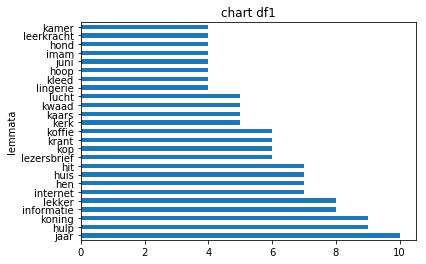

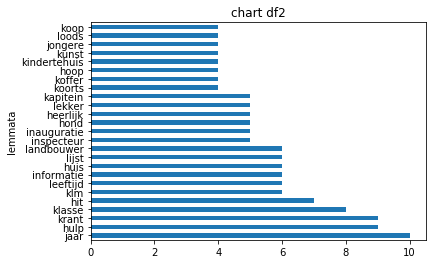

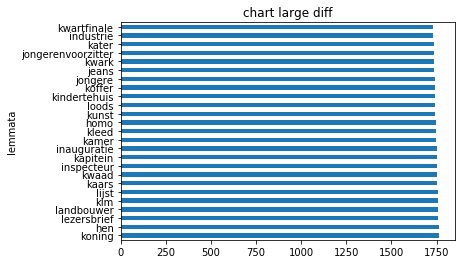

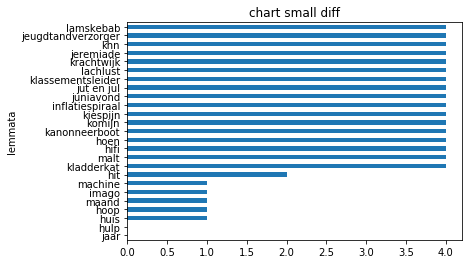

In [49]:
base_lexicon="anw"
corpus_to_search1="opensonar"
corpus_to_search2="chn"

# build frequency tables of two corpora

df_frequency_list1 = get_frequency_list(base_lexicon, "NOUN", corpus_to_search1)
display( df_frequency_list1.sort_values(ascending=False,by=['raw_freq']).head(25) )
display_df(df_frequency_list1.sort_values(ascending=True, by=['rank']).head(25), columns='raw_freq', title='chart df1', mode='chart' )

df_frequency_list2 = get_frequency_list(base_lexicon, "NOUN", corpus_to_search2)
display(df_frequency_list2.sort_values(ascending=False,by=['raw_freq']).head(25))
display_df(df_frequency_list2.sort_values(ascending=True, by=['rank']).head(25), columns='raw_freq', title='chart df2', mode='chart' )


# TODO: lemmata tonen die in 1 of 2 ontbreken

# compute the rank diff of lemmata in frequency tables

df_rankdiffs = get_rank_diff(df_frequency_list1, df_frequency_list2)

display(df_rankdiffs.sort_values(by=['rank_diff']).head(25))
display_df( df_rankdiffs.sort_values(ascending=False, by=['rank_diff']).head(25), columns='rank_diff', title='chart large diff', mode='chart' )
display_df( df_rankdiffs.sort_values(ascending=True, by=['rank_diff']).head(25), columns='rank_diff', title='chart small diff', mode='chart' )

## Case study: search in a corpus for wordforms of a lemma, which are not included in this lemma's paramadigm in a lexicon

In [53]:

base_lexicon="molex"
corpus_to_search="opensonar"

df = get_missing_wordforms(base_lexicon, "VERB", corpus_to_search)

df.to_csv( "missing_wordforms.csv", index=False)
#df = load_dataframe("missing_wordforms.csv")

display(df)


,lemma,pos,known_wordforms,unknown_wordforms
lemmata,,,,
achterliggen,achterliggen,VERB,"{achterlagen, liggen achter, lag achter, achterligt, lagen achter, achterliggend, achtergelegen, lig achter, achterliggen, ligt achter, achterlag, achterlig}",{achterliggende}
afstraffen,afstraffen,VERB,"{afstrafte, straffen af, straft af, afstraffen, afgestraft, afstraf, afstraft, straften af, afstraften, afstraffend, strafte af, straf af}",{afstraffende}
arresteren,arresteren,VERB,"{arresterend, arresteert, gearresteerd, arresteer, arresteerden, arresteren, arresteerde}",{gearresteerde}
automatiseren,automatiseren,VERB,"{automatiserend, automatiseert, automatiseer, automatiseerde, automatiseren, geautomatiseerd, automatiseerden}",{geautomatiseerde}
belangstellen,belangstellen,VERB,"{stelt belang, stel belang, belangstelde, belangstelden, belanggesteld, stelde belang, belangstelt, belangstel, stelden belang, stellen belang, belangstellend, belangstellen}",{belangstellenden}
bijkomen,bijkomen,VERB,"{bijgekomen, komen bij, bijkomen, bijkwam, bijkomt, bijkwamen, kom bij, bijkom, kwamen bij, kwam bij, komt bij, bijkomend}",{bijkomende}
bijpassen,bijpassen,VERB,"{paste bij, pas bij, past bij, pasten bij, bijgepast, bijpassend, bijpaste, bijpasten, bijpassen, bijpast, bijpas, passen bij}",{bijpassende}
boeien,boeien,VERB,"{boeiend, boeit, boeide, boei, geboeid, boeien, boeiden}",{boeiende}
buizen,buizen,VERB,"{buizen, buist, buisde, buis, gebuisd, buizend, buisden}",{gebuisde}


## Case study: Train a tagger with data from an annotated corpus, and do something cool

In [52]:
base_lexicon="molex"
corpus_to_search1="opensonar"
corpus_to_search2="chn"

# we have a given word, let's say: "loop"
some_word = "loop"

# get the paradigm of the lemma our word is a part of
query = lexicon_query(some_word, pos=None, lexicon=base_lexicon)
df_paradigm = search_lexicon(query, base_lexicon)
display(df_paradigm)

# gather some pattern including our word, out of an annotated corpus
# here: DET + ADJ + 'loop'
corpus_query = corpus_query_wordform(some_word)
df_corpus1 = search_corpus(corpus_query, corpus=corpus_to_search1, detailed_context=True)
display(df_corpus1)
df_corpus2 = search_corpus(corpus_query, corpus=corpus_to_search2, detailed_context=True)
display(df_corpus2)


df_all = concat_df([df_corpus1, df_corpus2], [corpus_to_search1, corpus_to_search2])
display(df_all)

# get a tagger trained with our corpus data
tagger = get_tagger(df_all)

# Use the trained tagger to tag unknown sentences
# The input must be like: tagger.tag(['today','is','a','beautiful','day'])

sentence = 'Mijn buurman kijkt door de loop van zijn geweer'
tagged_sentence = tagger.tag( sentence.split() )

print(tagged_sentence)


# Know we can lemmatize each occurence of our lemma in the new sentences

,Gender,Number,hyphenation,lemEntryId,lemPos,lemma,wordform,wordformId,wordformPos
0,http://universaldependencies.org/u/feat/Gender.html#Masc,http://universaldependencies.org/u/feat/Number.html#Sing,loop,http://rdf.ivdnt.org/lexica/diamant/entry/molex/45573,http://universaldependencies.org/u/pos/NOUN,loop,loop,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/89078,http://universaldependencies.org/u/pos/NOUN
1,http://universaldependencies.org/u/feat/Gender.html#Masc,http://universaldependencies.org/u/feat/Number.html#Plur,lo/pen,http://rdf.ivdnt.org/lexica/diamant/entry/molex/45573,http://universaldependencies.org/u/pos/NOUN,loop,lopen,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/156030,http://universaldependencies.org/u/pos/NOUN
2,http://universaldependencies.org/u/feat/Gender.html#Masc,http://universaldependencies.org/u/feat/Number.html#Sing,loop,http://rdf.ivdnt.org/lexica/diamant/entry/molex/45573,http://universaldependencies.org/u/pos/NOUN,loop,loop,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/89078,http://universaldependencies.org/u/pos/NOUN
3,,http://universaldependencies.org/u/feat/Number.html#Sing,loop,http://rdf.ivdnt.org/lexica/diamant/entry/molex/106637,http://universaldependencies.org/u/pos/VERB,lopen,loop,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/560193,http://universaldependencies.org/u/pos/VERB
4,,http://universaldependencies.org/u/feat/Number.html#Sing,loop,http://rdf.ivdnt.org/lexica/diamant/entry/molex/106637,http://universaldependencies.org/u/pos/VERB,lopen,loop,http://rdf.ivdnt.org/lexica/diamant/wordform/molex/822354,http://universaldependencies.org/u/pos/VERB


,lemma 0,lemma 1,lemma 2,lemma 3,lemma 4,lemma 5,lemma 6,lemma 7,lemma 8,lemma 9,...,word 1,word 2,word 3,word 4,word 5,word 6,word 7,word 8,word 9,word 10
0,intuïtie,kreeft,:,advies,:,lopen,niet,te,hard,van,...,kreeft,:,advies,:,loop,niet,te,hard,van,stapel
1,bewaken,zodat,ik,geen,risico,loop,ivm,inbraak,enz,enz,...,zodat,ik,geen,risico,loop,ivm,inbraken,enz,enz,Jij
2,rennen,naar,buiten,..,ik,lopen,naar,een,paar,auto\,...,naar,buiten,..,Ik,loop,naar,een,paar,auto\'s,die
3,denken,zullen,beïnvloeden,in,de,loop,van,de,volgend,25,...,zal,beïnvloeden,in,de,loop,van,de,volgende,25,jaar
4,nou,dat,kloppen,",",ik,loop,sinds,gisteren,niet,veel,...,dat,klopt,",",ik,loop,sinds,gisteren,niet,meer,zo
5,de,mens,er,in,de,loop,van,de,eeuw,mee,...,mens,er,in,de,loop,van,de,eeuwen,mee,deed
6,weer,over,gaan,in,de,loop,van,de,tijd,.,...,over,gaat,in,de,loop,van,de,tijd,.,Mij
7,boembaloe,ik,lopen,al,dag,het,lied,van,NOUN,PRON,...,van,None,None,None,None,None,None,None,None,None
8,due,to,a,positive,feedback,loop,.,As,sea,ice,...,to,a,positive,feedback,loop,.,As,sea,ice,melts
9,aan,men,hart,liggen,",",lopen,gewoon,verlore,;,weten,...,men,hart,ligt,",",loop,gewoon,verlore,;,weet,met


,lemma 0,lemma 1,lemma 2,lemma 3,lemma 4,lemma 5,lemma 6,lemma 7,lemma 8,lemma 9,...,word 1,word 2,word 3,word 4,word 5,word 6,word 7,word 8,word 9,word 10
0,met,het,gebruik,van,anti-epileptica,lopen,ik,tijdens,een,vakantie,...,het,gebruik,van,anti-epileptica,Loop,ik,tijdens,een,vakantie,extra
1,potentieel,handelen,die,in,de,loop,van,zijn,of,zij,...,handelen,die,in,de,loop,van,zijn,of,haar,leven
2,zaterdag,vergaderen,over,de,internationaal,loop,die,in,2003,voor,...,vergaderd,over,de,internationale,loop,die,in,2003,voor,het
3,ter,plek,zullen,in,de,loop,van,de,dag,een,...,plekke,zal,in,de,loop,van,de,dag,een,veiling
4,als,ik,door,bepaald,buurt,loop,dan,denken,ik,hé,...,ik,door,bepaalde,buurten,loop,dan,denk,ik,hé,misschien
5,zijn,waarlijk,opgestaan.Aansluiten,op,de,loop,zijn,de,Paasbrunch,organiseren,...,waarlijk,opgestaan.Aansluitend,op,de,loop,is,de,Paasbrunch,georganiseerd,None
6,bekampten,elkaar,op,de,sprint,loop,en,technisch,nummer,60,...,elkaar,op,de,sprint,loop,en,technische,nummers,60,meter
7,of,zij,traan,de,vrij,loop,de,dankdienst,worden,leiden,...,haar,tranen,de,vrije,loop,De,dankdienst,werd,geleid,door
8,trimloop,het,thema,van,de,loop,zijn,ëgeef,de,jeugd,...,Het,thema,van,de,loop,was,ëgeef,de,jeugd,de
9,en,half,marathon,lopen,de,loop,die,om,half,acht,...,halve,marathon,lopen,De,loop,die,om,half,acht,s


lemma 0     lemma 1                lemma 2   lemma 3  \
opensonar 0    intuïtie      kreeft                      :    advies   
          1     bewaken       zodat                     ik      geen   
          2      rennen        naar                 buiten        ..   
          3      denken      zullen            beïnvloeden        in   
          4         nou         dat                kloppen         ,   
          5          de        mens                     er        in   
          6        weer        over                   gaan        in   
          7   boembaloe          ik                  lopen        al   
          8         due          to                      a  positive   
          9         aan         men                   hart    liggen   
chn       0         met         het                gebruik       van   
          1  potentieel    handelen                    die        in   
          2    zaterdag  vergaderen                   over        de   
          3         ter        plek                 zullen        in   
          4         als          ik                   door   bepaald   
          5        zijn    waarlijk  opgestaan.Aansluiten        op   
          6   bekampten      elkaar                     op        de   
          7          of         zij                  traan        de   
          8    trimloop         het                  thema       van   
          9          en        half               marathon     lopen   

                     lemma 4 lemma 5 lemma 6     lemma 7     lemma 8  \
opensonar 0                :   lopen    niet          te        hard   
          1           risico    loop     ivm     inbraak         enz   
          2               ik   lopen    naar         een        paar   
          3               de    loop     van          de     volgend   
          4               ik    loop   sinds    gisteren        niet   
          5               de    loop     van          de        eeuw   
          6               de    loop     van          de        tijd   
          7              dag     het    lied         van        NOUN   
          8         feedback    loop       .          As         sea   
          9                ,   lopen  gewoon     verlore           ;   
chn       0  anti-epileptica   lopen      ik     tijdens         een   
          1               de    loop     van        zijn          of   
          2   internationaal    loop     die          in        2003   
          3               de    loop     van          de         dag   
          4            buurt    loop     dan      denken          ik   
          5               de    loop    zijn          de  Paasbrunch   
          6           sprint    loop      en   technisch      nummer   
          7             vrij    loop      de  dankdienst      worden   
          8               de    loop    zijn       ëgeef          de   
          9               de    loop     die          om        half   

                 lemma 9  ...     word 1                  word 2    word 3  \
opensonar 0          van  ...     kreeft                       :    advies   
          1          enz  ...      zodat                      ik      geen   
          2        auto\  ...       naar                  buiten        ..   
          3           25  ...        zal             beïnvloeden        in   
          4         veel  ...        dat                   klopt         ,   
          5          mee  ...       mens                      er        in   
          6            .  ...       over                    gaat        in   
          7         PRON  ...        van                    None      None   
          8          ice  ...         to                       a  positive   
          9        weten  ...        men                    hart      ligt   
chn       0     vakantie  ...        het                 gebruik       van   
          1          zij  ...   handelen              

[('Mijn', 'VERB'), ('buurman', 'PRON'), ('kijkt', 'VERB'), ('door', 'ADP'), ('de', 'DET'), ('loop', 'NOUN'), ('van', 'ADP'), ('zijn', 'NOUN'), ('geweer', 'ADV')]
